<a href="https://colab.research.google.com/github/HOLY-GOD/CODSOFT/blob/main/Movie_Rating_Prediction_with_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Importing the necessary packages and modules

# !pip install dtale

import warnings
warnings.filterwarnings('ignore')

import category_encoders as ce
# import dtale
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
import statsmodels.api as sm
import statsmodels.regression.linear_model as smf
import timeit
import xgboost as xgb

from imblearn.over_sampling import RandomOverSampler
from numba import jit, cuda
# from pandas_profiling import ProfileReport
# from pycaret.classification import *
# from pycaret.regression import *
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from statsmodels.formula.api import ols
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
from wordcloud import WordCloud

sns.set()
%matplotlib inline

In [6]:
# Reading the dataset into a data frame
# Getting error as ''utf-8' codec can't decode byte 0xe1 in position 76763: invalid continuation byte'
# So using 'encoding = 'latin-1'

df = pd.read_csv("/content/IMDb Movies India.csv", encoding = 'latin-1')
df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


In [8]:
df.describe()

,Rating
count,7919.000000
mean,5.841621
std,1.381777
min,1.100000
25%,4.900000
50%,6.000000
75%,6.800000
max,10.000000


In [9]:
# Checking for duplicate rows

df.duplicated().sum()

6

In [10]:
# Spliting the data based on target column
# If the target column is nan or null then it will go into the test df

rest_df, test_df = [x for y, x in df.groupby(df['Rating'].isna())]

In [11]:
test_df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
2,#Homecoming,(2021),90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana
4,...And Once Again,(2010),105 min,Drama,NaN,NaN,Amol Palekar,Rajat Kapoor,Rituparna Sengupta,Antara Mali
7,.in for Motion,(2008),59 min,Documentary,NaN,NaN,Anirban Datta,NaN,NaN,NaN
14,101 Ratein,(1990),NaN,Thriller,NaN,NaN,Harish,Saraswati,Disco Shanti,NaN


In [12]:
rest_df.head()

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1,#Gadhvi (He thought he was Gandhi),(2019),109 min,Drama,7.0,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid
3,#Yaaram,(2019),110 min,"Comedy, Romance",4.4,35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor
5,...Aur Pyaar Ho Gaya,(1997),147 min,"Comedy, Drama, Musical",4.7,827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor
6,...Yahaan,(2005),142 min,"Drama, Romance, War",7.4,"1,086",Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma
8,?: A Question Mark,(2012),82 min,"Horror, Mystery, Thriller",5.6,326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia


In [13]:
# Train test (validation) split

train_df, validation_df = train_test_split(rest_df, train_size = 0.75, random_state = 101)
train_df.head(2)

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
11500,Rahi,(1953),139 min,Drama,7.0,28,Khwaja Ahmad Abbas,Dev Anand,Nalini Jaywant,Balraj Sahni
5167,Gooli,(2008),138 min,"Action, Drama, Romance",6.4,80,P. Satya,Sudeep,Mamta Mohandas,Kishore Kumar G.


In [14]:
validation_df.head(2)

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
12679,Seeking Happily Ever After,(2018),104 min,"Drama, Romance",6.8,"1,117",Harish Vyas,Shivani Raghuvanshi,Anshuman Jha,Ekavali Khanna
12294,Samar,(1998),126 min,Drama,7.5,31,Shyam Benegal,Rajeshwari Sachdev,Rajit Kapoor,Ravi Jhankal


In [15]:
# Checking for duplicate rows

train_df.duplicated().sum()

0

In [16]:
validation_df.duplicated().sum()

0

In [17]:
test_df.duplicated().sum()

6

We see that all the duplicate values are in test dataframe, proceeding to remove the duplicates.

In [18]:
test_df[df.duplicated(keep = False)]

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
1249,Arab Ka Sona - Abu Kaalia,(1979),NaN,Action,NaN,NaN,Master Bhagwan,Meena Rai,Dara Singh,NaN
1250,Arab Ka Sona - Abu Kaalia,(1979),NaN,Action,NaN,NaN,Master Bhagwan,Meena Rai,Dara Singh,NaN
1768,Balidan,(1992),NaN,Drama,NaN,NaN,NaN,NaN,NaN,NaN
1769,Balidan,(1992),NaN,Drama,NaN,NaN,NaN,NaN,NaN,NaN
4722,First Time - Pehli Baar,(2009),NaN,NaN,NaN,NaN,Raja Bundela,Zeenat Aman,Nitin Arora,Raj Babbar
4723,First Time - Pehli Baar,(2009),NaN,NaN,NaN,NaN,Raja Bundela,Zeenat Aman,Nitin Arora,Raj Babbar
9712,Musafir,NaN,NaN,Thriller,NaN,NaN,Shiva Dagar,NaN,NaN,NaN
9713,Musafir,NaN,NaN,Thriller,NaN,NaN,Shiva Dagar,NaN,NaN,NaN
13068,Shivani,(2019),NaN,Crime,NaN,NaN,Ugresh Prasad Ujala,Santosh,NaN,NaN
13069,Shivani,(2019),NaN,Crime,NaN,NaN,Ugresh Prasad Ujala,Santosh,NaN,NaN


In [19]:
# Removing the duplicate values

test_df.drop_duplicates(inplace = True)
test_df.duplicated().sum()

0

In [20]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5939 entries, 11500 to 9574
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      5939 non-null   object 
 1   Year      5939 non-null   object 
 2   Duration  4393 non-null   object 
 3   Genre     5860 non-null   object 
 4   Rating    5939 non-null   float64
 5   Votes     5939 non-null   object 
 6   Director  5935 non-null   object 
 7   Actor 1   5837 non-null   object 
 8   Actor 2   5783 non-null   object 
 9   Actor 3   5713 non-null   object 
dtypes: float64(1), object(9)
memory usage: 510.4+ KB


In [21]:
train_df.describe()

,Rating
count,5939.000000
mean,5.859118
std,1.384323
min,1.100000
25%,4.900000
50%,6.000000
75%,6.900000
max,9.700000


In [22]:
train_df.describe(include = 'all')

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
count,5939,5939,4393,5860,5939.000000,5939,5935,5837,5783,5713
unique,5612,92,172,380,NaN,1643,2623,2103,2385,2566
top,Sanjog,(2019),120 min,Drama,NaN,7,Mahesh Bhatt,Dharmendra,Rekha,Pran
freq,4,192,132,910,NaN,171,39,106,54,57
mean,NaN,NaN,NaN,NaN,5.859118,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,1.384323,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,1.100000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,4.900000,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,6.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,6.900000,NaN,NaN,NaN,NaN,NaN


In [23]:
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1980 entries, 12679 to 2263
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      1980 non-null   object 
 1   Year      1980 non-null   object 
 2   Duration  1458 non-null   object 
 3   Genre     1957 non-null   object 
 4   Rating    1980 non-null   float64
 5   Votes     1980 non-null   object 
 6   Director  1979 non-null   object 
 7   Actor 1   1957 non-null   object 
 8   Actor 2   1936 non-null   object 
 9   Actor 3   1914 non-null   object 
dtypes: float64(1), object(9)
memory usage: 170.2+ KB


In [24]:
validation_df.describe()

,Rating
count,1980.000000
mean,5.789141
std,1.373123
min,1.600000
25%,4.900000
50%,5.900000
75%,6.800000
max,10.000000


In [25]:
validation_df.describe(include = 'all')

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
count,1980,1980,1458,1957,1980.000000,1980,1979,1957,1936,1914
unique,1955,89,144,243,NaN,750,1188,920,1066,1114
top,Thokar,(2017),135 min,Drama,NaN,9,Hrishikesh Mukherjee,Jeetendra,Rekha,Pran
freq,3,66,43,267,NaN,65,14,41,25,18
mean,NaN,NaN,NaN,NaN,5.789141,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,1.373123,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,1.600000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,4.900000,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,5.900000,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,6.800000,NaN,NaN,NaN,NaN,NaN


In [26]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7584 entries, 0 to 15507
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      7584 non-null   object 
 1   Year      7057 non-null   object 
 2   Duration  1388 non-null   object 
 3   Genre     5810 non-null   object 
 4   Rating    0 non-null      float64
 5   Votes     1 non-null      object 
 6   Director  7065 non-null   object 
 7   Actor 1   6094 non-null   object 
 8   Actor 2   5403 non-null   object 
 9   Actor 3   4736 non-null   object 
dtypes: float64(1), object(9)
memory usage: 651.8+ KB


In [27]:
test_df.describe()

,Rating
count,0.0
mean,NaN
std,NaN
min,NaN
25%,NaN
50%,NaN
75%,NaN
max,NaN


In [28]:
test_df.describe(include = 'all')

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
count,7584,7057,1388,5810,0.0,1,7065,6094,5403,4736
unique,7122,101,144,242,NaN,1,3766,2956,2893,2603
top,Mamta,(2021),120 min,Drama,NaN,$5.16M,Jayant Desai,Master Bhagwan,Helen,Jeevan
freq,6,314,65,1602,NaN,1,52,61,38,34
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
train_df.shape

(5939, 10)

In [30]:
validation_df.shape

(1980, 10)

In [31]:
test_df.shape

(7584, 10)

### Handling missing values

In [32]:
# Checking for missing values
# Missing values in each column

train_missing = list(train_df.isnull().sum())
val_missing = list(validation_df.isnull().sum())
test_misisng = list(test_df.isnull().sum())

In [33]:
# Checking the percentage of missing values
# Percentage of missing values in each column

train_missing_percent = list(train_df.isnull().sum() / len(train_df) * 100)
val_missing_percent = list(validation_df.isnull().sum() / len(validation_df) * 100)
test_misisng_percent = list(test_df.isnull().sum() / len(test_df) * 100)

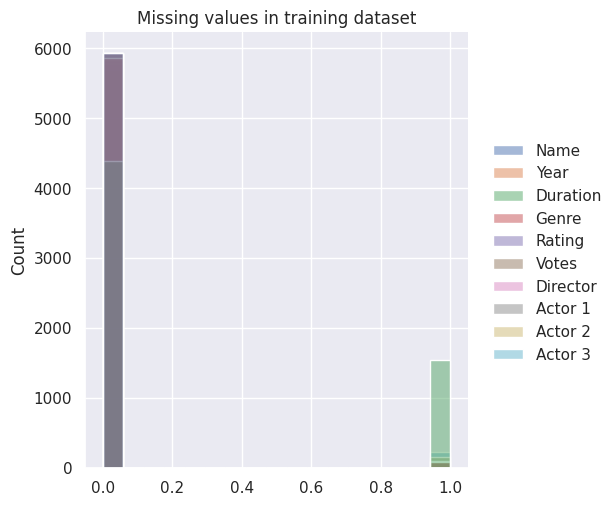

In [34]:
sns.displot(train_df.isnull())
plt.title("Missing values in training dataset")
plt.show()

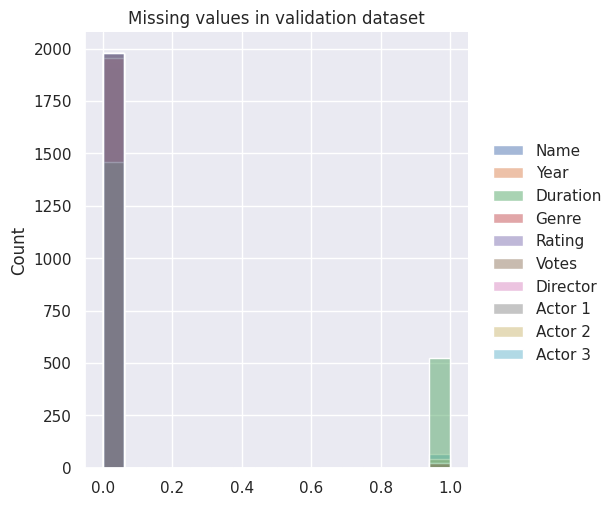

In [35]:
sns.displot(validation_df.isnull())
plt.title("Missing values in validation dataset")
plt.show()

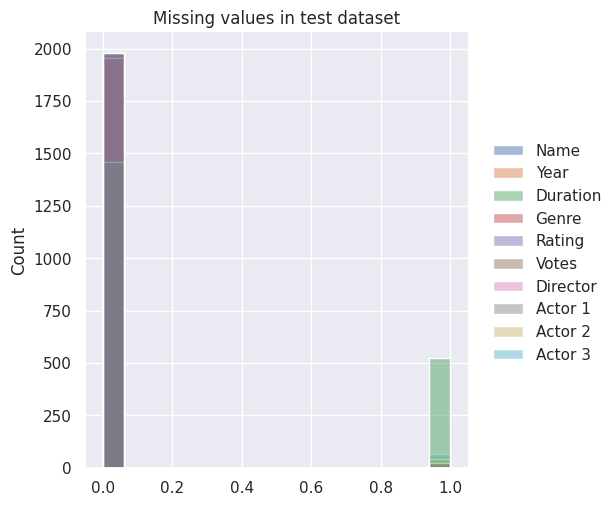

In [36]:
sns.displot(validation_df.isnull())
plt.title("Missing values in test dataset")
plt.show()

In [37]:
# Missing values dataframe

missing_df = pd.DataFrame({'Columns' : list(train_df.columns), 'Train_missing' : train_missing, 'Percent_Train_missing' : train_missing_percent,
                'Validation_missing' : val_missing, 'Percent_Val_missing' : val_missing_percent, 'Test_missing' : test_misisng,
                           'Percent_Test_missing' : test_misisng_percent})
missing_df

,Columns,Train_missing,Percent_Train_missing,Validation_missing,Percent_Val_missing,Test_missing,Percent_Test_missing
0,Name,0,0.000000,0,0.000000,0,0.000000
1,Year,0,0.000000,0,0.000000,527,6.948840
2,Duration,1546,26.031318,522,26.363636,6196,81.698312
3,Genre,79,1.330190,23,1.161616,1774,23.391350
4,Rating,0,0.000000,0,0.000000,7584,100.000000
5,Votes,0,0.000000,0,0.000000,7583,99.986814
6,Director,4,0.067351,1,0.050505,519,6.843354
7,Actor 1,102,1.717461,23,1.161616,1490,19.646624
8,Actor 2,156,2.626705,44,2.222222,2181,28.757911
9,Actor 3,226,3.805354,66,3.333333,2848,37.552743


In [38]:
# Filing the missing year values in test set based on values of training set
# Converting the year column to a number datatype from object datatype

train_df['Year'] = train_df['Year'].str.extract('([0-9]+)').astype(int)
train_df.head(2)

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
11500,Rahi,1953,139 min,Drama,7.0,28,Khwaja Ahmad Abbas,Dev Anand,Nalini Jaywant,Balraj Sahni
5167,Gooli,2008,138 min,"Action, Drama, Romance",6.4,80,P. Satya,Sudeep,Mamta Mohandas,Kishore Kumar G.


In [39]:
validation_df['Year'] = validation_df['Year'].str.extract('([0-9]+)').astype(int)
validation_df.head(2)

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
12679,Seeking Happily Ever After,2018,104 min,"Drama, Romance",6.8,"1,117",Harish Vyas,Shivani Raghuvanshi,Anshuman Jha,Ekavali Khanna
12294,Samar,1998,126 min,Drama,7.5,31,Shyam Benegal,Rajeshwari Sachdev,Rajit Kapoor,Ravi Jhankal


In [40]:
test_df['Year'] = test_df['Year'].str.replace(r'[()]', '', regex=True)
test_df.head(2)

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,NaN,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
2,#Homecoming,2021,90 min,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana


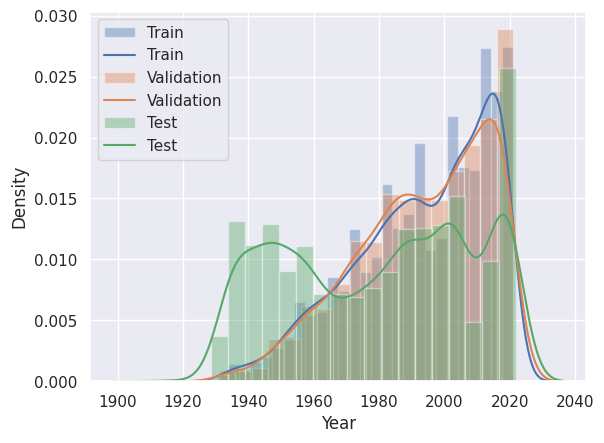

In [41]:
sns.distplot(train_df['Year'].values, label = "Train")
sns.distplot(validation_df['Year'].values, label = "Validation")
sns.distplot(test_df['Year'].values, label = "Test")
plt.legend(['Train', 'Train', 'Validation', 'Validation', 'Test', 'Test'])
plt.xlabel('Year')

plt.show()

In [42]:
mode_year = train_df['Year'].mode()
test_df['Year'] = test_df['Year'].fillna(2019)

In [43]:
# Checking why the column still shows null values

test_df['Year'].info()

<class 'pandas.core.series.Series'>
Int64Index: 7584 entries, 0 to 15507
Series name: Year
Non-Null Count  Dtype 
--------------  ----- 
7584 non-null   object
dtypes: object(1)
memory usage: 118.5+ KB


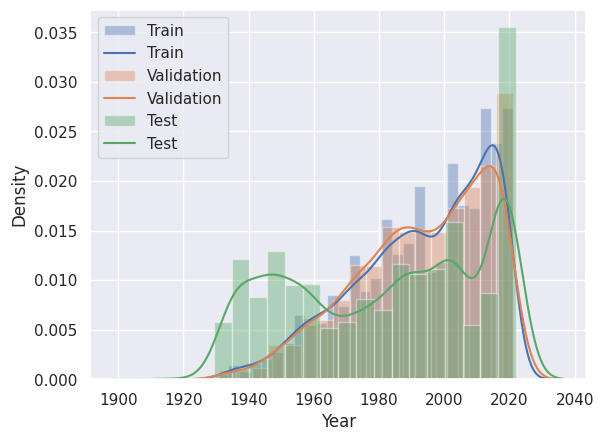

In [44]:
sns.distplot(train_df['Year'].values, label = "Train")
sns.distplot(validation_df['Year'].values, label = "Validation")
sns.distplot(test_df['Year'].values, label = "Test")
plt.legend(['Train', 'Train', 'Validation', 'Validation', 'Test', 'Test'])
plt.xlabel('Year')

plt.show()

In [45]:
# Filling the missing values in duration column

train_df['Duration'] = train_df['Duration'].str.extract('([0-9]+)').astype(float)
train_df.head(2)

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
11500,Rahi,1953,139.0,Drama,7.0,28,Khwaja Ahmad Abbas,Dev Anand,Nalini Jaywant,Balraj Sahni
5167,Gooli,2008,138.0,"Action, Drama, Romance",6.4,80,P. Satya,Sudeep,Mamta Mohandas,Kishore Kumar G.


In [46]:
validation_df['Duration'] = validation_df['Duration'].str.extract('([0-9]+)').astype(float)
validation_df.head(2)

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
12679,Seeking Happily Ever After,2018,104.0,"Drama, Romance",6.8,"1,117",Harish Vyas,Shivani Raghuvanshi,Anshuman Jha,Ekavali Khanna
12294,Samar,1998,126.0,Drama,7.5,31,Shyam Benegal,Rajeshwari Sachdev,Rajit Kapoor,Ravi Jhankal


In [47]:
test_df['Duration'] = test_df['Duration'].str.extract('([0-9]+)').astype(float)
test_df.head(2)

,Name,Year,Duration,Genre,Rating,Votes,Director,Actor 1,Actor 2,Actor 3
0,,2019,NaN,Drama,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia
2,#Homecoming,2021,90.0,"Drama, Musical",NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana


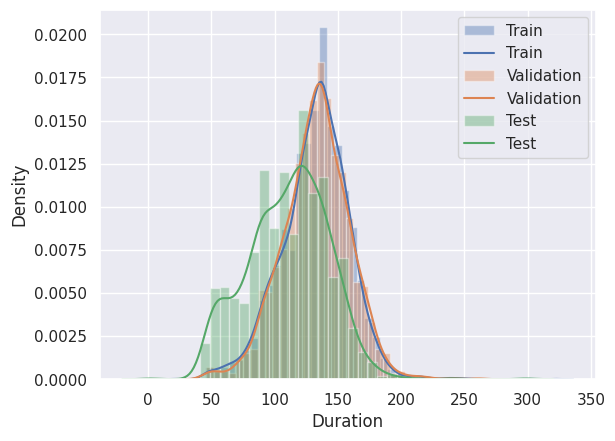

In [48]:
# Checking the distribution of duration

sns.distplot(train_df['Duration'].values, label = "Duration")
sns.distplot(validation_df['Duration'].values, label = "Validation")
sns.distplot(test_df['Duration'].values, label = "Test")
plt.legend(['Train', 'Train', 'Validation', 'Validation', 'Test', 'Test'])
plt.xlabel('Duration')

plt.show()

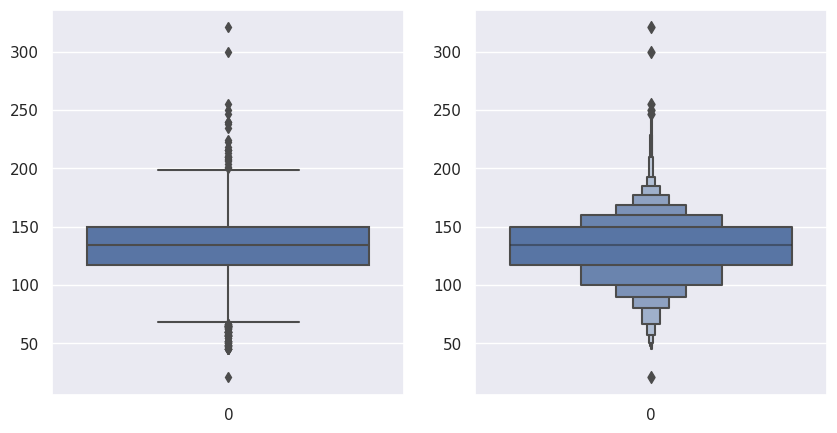

In [49]:
# Checking fo outliers to see if we need to fill the missing values with mean or median

plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
sns.boxplot(train_df['Duration'].values)

plt.subplot(1, 2, 2)
sns.boxenplot(train_df['Duration'].values)

plt.show()

In [50]:
# Filling the missing values

median_duration = train_df['Duration'].median()

train_df['Duration'] = train_df['Duration'].fillna(median_duration)
validation_df['Duration'] = validation_df['Duration'].fillna(median_duration)
test_df['Duration'] = test_df['Duration'].fillna(median_duration)

train_df['Duration'].info()

<class 'pandas.core.series.Series'>
Int64Index: 5939 entries, 11500 to 9574
Series name: Duration
Non-Null Count  Dtype  
--------------  -----  
5939 non-null   float64
dtypes: float64(1)
memory usage: 92.8 KB


In [51]:
validation_df['Duration'].info()

<class 'pandas.core.series.Series'>
Int64Index: 1980 entries, 12679 to 2263
Series name: Duration
Non-Null Count  Dtype  
--------------  -----  
1980 non-null   float64
dtypes: float64(1)
memory usage: 30.9 KB


In [52]:
test_df['Duration'].info()

<class 'pandas.core.series.Series'>
Int64Index: 7584 entries, 0 to 15507
Series name: Duration
Non-Null Count  Dtype  
--------------  -----  
7584 non-null   float64
dtypes: float64(1)
memory usage: 118.5 KB


In [53]:
# Filling the missing values in genre column

def expand_genre(df):
    genres_df = df['Genre'].str.split(', ', expand = True)
    df = pd.concat([df, genres_df], axis = 1)
    df.rename(columns = {0 : 'Genre_1', 1 : 'Genre_2', 2 : 'Genre_3'}, inplace = True)
    df.drop('Genre', axis = 1, inplace = True)
    return df

In [54]:
train_df = expand_genre(train_df)
validation_df = expand_genre(validation_df)
test_df = expand_genre(test_df)

In [55]:
print("Train Genre_1 missing :", (train_df['Genre_1'].isnull().sum() / len(train_df['Genre_1']) * 100))
print("Train Genre_2 missing :", (train_df['Genre_2'].isnull().sum() / len(train_df['Genre_2']) * 100))
print("Train Genre_3 missing :", (train_df['Genre_3'].isnull().sum() / len(train_df['Genre_3']) * 100))
print("Validation Genre_1 missing :", (validation_df['Genre_1'].isnull().sum() / len(validation_df['Genre_1']) * 100))
print("Validation Genre_2 missing :", (validation_df['Genre_2'].isnull().sum() / len(validation_df['Genre_2']) * 100))
print("Validation Genre_3 missing :", (validation_df['Genre_3'].isnull().sum() / len(validation_df['Genre_3']) * 100))
print("Test Genre_1 missing :", (test_df['Genre_1'].isnull().sum() / len(test_df['Genre_1']) * 100))
print("Test Genre_2 missing :", (test_df['Genre_2'].isnull().sum() / len(test_df['Genre_2']) * 100))
print("Test Genre_3 missing :", (test_df['Genre_3'].isnull().sum() / len(test_df['Genre_3']) * 100))

Train Genre_1 missing : 1.3301902677218387
Train Genre_2 missing : 35.948812931469945
Train Genre_3 missing : 64.65734972217545
Validation Genre_1 missing : 1.1616161616161615
Validation Genre_2 missing : 34.24242424242424
Validation Genre_3 missing : 63.98989898989898
Test Genre_1 missing : 23.39135021097046
Test Genre_2 missing : 85.5617088607595
Test Genre_3 missing : 94.35654008438819


In [56]:
def drop_genre(df):
    df.drop(['Genre_2','Genre_3'], axis = 1, inplace = True)
    df.rename(columns = {'Genre_1' : 'Genre'}, inplace = True)
    return df

train_df = drop_genre(train_df)
validation_df = drop_genre(validation_df)
test_df = drop_genre(test_df)

In [57]:
train_df.head(2)

,Name,Year,Duration,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Genre
11500,Rahi,1953,139.0,7.0,28,Khwaja Ahmad Abbas,Dev Anand,Nalini Jaywant,Balraj Sahni,Drama
5167,Gooli,2008,138.0,6.4,80,P. Satya,Sudeep,Mamta Mohandas,Kishore Kumar G.,Action


In [58]:
validation_df.head(2)

,Name,Year,Duration,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Genre
12679,Seeking Happily Ever After,2018,104.0,6.8,"1,117",Harish Vyas,Shivani Raghuvanshi,Anshuman Jha,Ekavali Khanna,Drama
12294,Samar,1998,126.0,7.5,31,Shyam Benegal,Rajeshwari Sachdev,Rajit Kapoor,Ravi Jhankal,Drama


In [59]:
test_df.head(2)

,Name,Year,Duration,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Genre
0,,2019,134.0,NaN,NaN,J.S. Randhawa,Manmauji,Birbal,Rajendra Bhatia,Drama
2,#Homecoming,2021,90.0,NaN,NaN,Soumyajit Majumdar,Sayani Gupta,Plabita Borthakur,Roy Angana,Drama


In [60]:
# Filling the missing values based on Mode Imputaion method

mode_per_year = train_df.groupby('Year')['Genre'].apply(lambda x: x.mode().iloc[0])    # Gives a df with node of each year
train_df['Genre'] = train_df.apply(lambda row: mode_per_year[row['Year']] if pd.isnull(row['Genre']) else row['Genre'], axis=1)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5939 entries, 11500 to 9574
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      5939 non-null   object 
 1   Year      5939 non-null   int64  
 2   Duration  5939 non-null   float64
 3   Rating    5939 non-null   float64
 4   Votes     5939 non-null   object 
 5   Director  5935 non-null   object 
 6   Actor 1   5837 non-null   object 
 7   Actor 2   5783 non-null   object 
 8   Actor 3   5713 non-null   object 
 9   Genre     5939 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 510.4+ KB


In [61]:
validation_df['Genre'] = validation_df.apply(lambda row: mode_per_year[row['Year']] if pd.isnull(row['Genre']) else row['Genre'], axis=1)
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1980 entries, 12679 to 2263
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      1980 non-null   object 
 1   Year      1980 non-null   int64  
 2   Duration  1980 non-null   float64
 3   Rating    1980 non-null   float64
 4   Votes     1980 non-null   object 
 5   Director  1979 non-null   object 
 6   Actor 1   1957 non-null   object 
 7   Actor 2   1936 non-null   object 
 8   Actor 3   1914 non-null   object 
 9   Genre     1980 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 170.2+ KB


In [62]:
# Filling the missing values of the genre in test df with the mode of train df

genre_mode = train_df['Genre'].mode()
genre_mode

0    Drama
Name: Genre, dtype: object

In [63]:
test_df['Genre'] = test_df['Genre'].fillna('Drama')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7584 entries, 0 to 15507
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      7584 non-null   object 
 1   Year      7584 non-null   object 
 2   Duration  7584 non-null   float64
 3   Rating    0 non-null      float64
 4   Votes     1 non-null      object 
 5   Director  7065 non-null   object 
 6   Actor 1   6094 non-null   object 
 7   Actor 2   5403 non-null   object 
 8   Actor 3   4736 non-null   object 
 9   Genre     7584 non-null   object 
dtypes: float64(2), object(8)
memory usage: 651.8+ KB


In [64]:
# Treating the missing values in Votes column in test dataset
# Checking the unique values

set(test_df['Votes'].tolist())

{'$5.16M', nan}

In [65]:
# The one non null value seems to be a wrong value, making it to nan

test_df.index[test_df['Votes'] == '$5.16M']

Int64Index([9500], dtype='int64')

In [66]:
test_df['Votes'][9500] = pd.NA

In [67]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7584 entries, 0 to 15507
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      7584 non-null   object 
 1   Year      7584 non-null   object 
 2   Duration  7584 non-null   float64
 3   Rating    0 non-null      float64
 4   Votes     0 non-null      object 
 5   Director  7065 non-null   object 
 6   Actor 1   6094 non-null   object 
 7   Actor 2   5403 non-null   object 
 8   Actor 3   4736 non-null   object 
 9   Genre     7584 non-null   object 
dtypes: float64(2), object(8)
memory usage: 909.8+ KB


In [68]:
# Filling the missing values in the names of Directors and actors as 'Not Available'

def fill_names(df):
    df['Director'] = df['Director'].fillna('Not Available')
    df['Actor 1'] = df['Actor 1'].fillna('Not Available')
    df['Actor 2'] = df['Actor 2'].fillna('Not Available')
    df['Actor 3'] = df['Actor 3'].fillna('Not Available')
    return df

train_df = fill_names(train_df)
validation_df = fill_names(validation_df)
test_df = fill_names(test_df)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5939 entries, 11500 to 9574
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      5939 non-null   object 
 1   Year      5939 non-null   int64  
 2   Duration  5939 non-null   float64
 3   Rating    5939 non-null   float64
 4   Votes     5939 non-null   object 
 5   Director  5939 non-null   object 
 6   Actor 1   5939 non-null   object 
 7   Actor 2   5939 non-null   object 
 8   Actor 3   5939 non-null   object 
 9   Genre     5939 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 510.4+ KB


In [69]:
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1980 entries, 12679 to 2263
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      1980 non-null   object 
 1   Year      1980 non-null   int64  
 2   Duration  1980 non-null   float64
 3   Rating    1980 non-null   float64
 4   Votes     1980 non-null   object 
 5   Director  1980 non-null   object 
 6   Actor 1   1980 non-null   object 
 7   Actor 2   1980 non-null   object 
 8   Actor 3   1980 non-null   object 
 9   Genre     1980 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 170.2+ KB


In [70]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7584 entries, 0 to 15507
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      7584 non-null   object 
 1   Year      7584 non-null   object 
 2   Duration  7584 non-null   float64
 3   Rating    0 non-null      float64
 4   Votes     0 non-null      object 
 5   Director  7584 non-null   object 
 6   Actor 1   7584 non-null   object 
 7   Actor 2   7584 non-null   object 
 8   Actor 3   7584 non-null   object 
 9   Genre     7584 non-null   object 
dtypes: float64(2), object(8)
memory usage: 909.8+ KB


In [71]:
# Checking for missing values

train_missing = list(train_df.isnull().sum())
val_missing = list(validation_df.isnull().sum())
test_misisng = list(test_df.isnull().sum())

train_missing_percent = list(train_df.isnull().sum() / len(train_df) * 100)
val_missing_percent = list(validation_df.isnull().sum() / len(validation_df) * 100)
test_misisng_percent = list(test_df.isnull().sum() / len(test_df) * 100)

missing_df = pd.DataFrame({'Columns' : list(train_df.columns), 'Train_missing' : train_missing, 'Percent_Train_missing' : train_missing_percent,
                'Validation_missing' : val_missing, 'Percent_Val_missing' : val_missing_percent, 'Test_missing' : test_misisng,
                           'Percent_Test_missing' : test_misisng_percent})
missing_df

,Columns,Train_missing,Percent_Train_missing,Validation_missing,Percent_Val_missing,Test_missing,Percent_Test_missing
0,Name,0,0.0,0,0.0,0,0.0
1,Year,0,0.0,0,0.0,0,0.0
2,Duration,0,0.0,0,0.0,0,0.0
3,Rating,0,0.0,0,0.0,7584,100.0
4,Votes,0,0.0,0,0.0,7584,100.0
5,Director,0,0.0,0,0.0,0,0.0
6,Actor 1,0,0.0,0,0.0,0,0.0
7,Actor 2,0,0.0,0,0.0,0,0.0
8,Actor 3,0,0.0,0,0.0,0,0.0
9,Genre,0,0.0,0,0.0,0,0.0


### Exploratory Data Analysis

In [72]:
# Exploring the signficance of every variable

filled_df = pd.concat([train_df, validation_df], axis = 0)
filled_df.head(2)

,Name,Year,Duration,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Genre
11500,Rahi,1953,139.0,7.0,28,Khwaja Ahmad Abbas,Dev Anand,Nalini Jaywant,Balraj Sahni,Drama
5167,Gooli,2008,138.0,6.4,80,P. Satya,Sudeep,Mamta Mohandas,Kishore Kumar G.,Action


In [73]:
filled_df['Votes'].info

<bound method Series.info of 11500        28
5167         80
4825         29
3597        395
15080        40
          ...  
65            5
2648      2,236
9224         72
6737         28
2263     22,777
Name: Votes, Length: 7919, dtype: object>

In [74]:
# Votes should be a numberic column, but it is of object datatype, converting the column to numeric datatype

filled_df['Votes'] = filled_df['Votes'].str.replace(',','').astype(int)
train_df['Votes'] = train_df['Votes'].str.replace(',','').astype(int)
validation_df['Votes'] = validation_df['Votes'].str.replace(',','').astype(int)

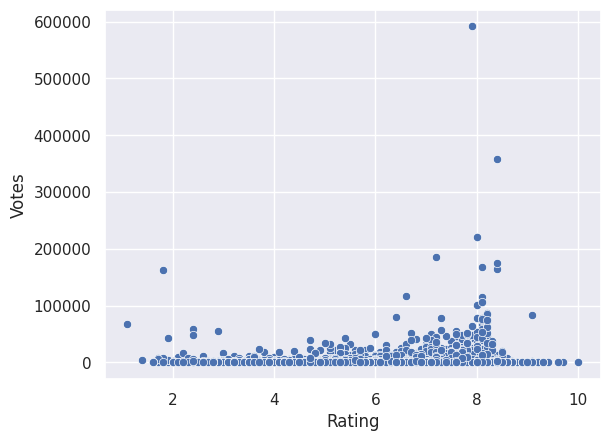

In [75]:
sns.scatterplot(x = filled_df['Rating'], y = filled_df['Votes'])
plt.show()

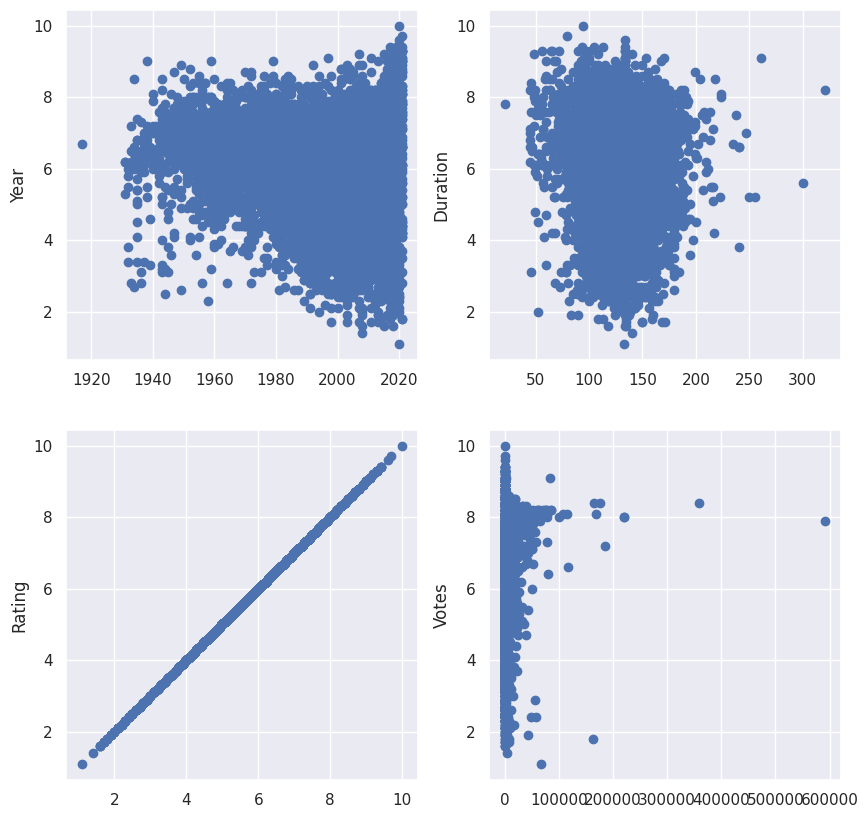

In [76]:
# Visualising the data to understand the significance

numeric_cols = filled_df.select_dtypes(include = np.number)
col_names = list(numeric_cols.columns)
col_index = 0
plt_rows = 2
plt_cols = 2

fig, ax = plt.subplots(nrows = plt_rows, ncols = plt_cols, figsize = (10, 10))

for row_count in range(plt_rows):
    for col_count in range(plt_cols):
        ax[row_count][col_count].scatter(x = filled_df[col_names[col_index]], y = filled_df['Rating'], c = ['b'])
        ax[row_count][col_count].set_ylabel(col_names[col_index])
        col_index += 1

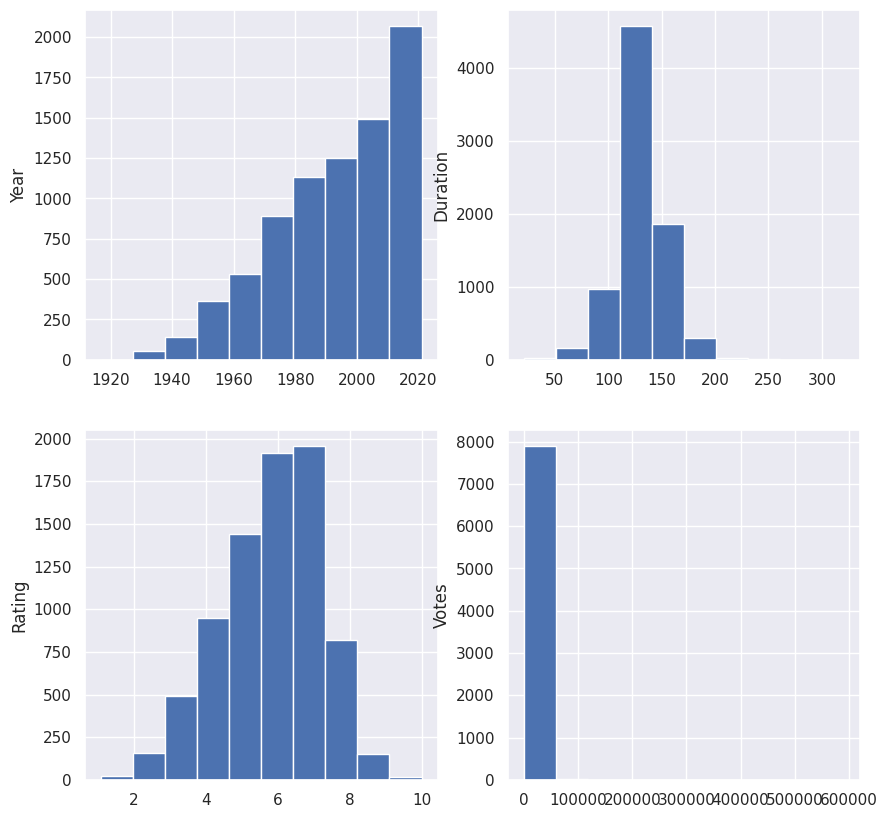

In [78]:
# Checking the distributions of each column

col_index = 0

fig, ax = plt.subplots(nrows = plt_rows, ncols = plt_cols, figsize = (10, 10))

for row_count in range(plt_rows):
    for col_count in range(plt_cols):
        ax[row_count][col_count].hist(filled_df[col_names[col_index]])
        ax[row_count][col_count].set_ylabel(col_names[col_index])
        col_index += 1

In [83]:
filled_df.head(2)

,Name,Year,Duration,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Genre
11500,Rahi,1953,139.0,7.0,28,Khwaja Ahmad Abbas,Dev Anand,Nalini Jaywant,Balraj Sahni,Drama
5167,Gooli,2008,138.0,6.4,80,P. Satya,Sudeep,Mamta Mohandas,Kishore Kumar G.,Action


In [88]:
top_movies_overall = filled_df.nlargest(10, 'Rating')

# Find the top 10 movies per year
top_movies_per_year = filled_df.groupby('Year').apply(lambda x: x.nlargest(10, 'Rating')).reset_index(drop=True)

# Display the results
print("Top 10 Movies Overall:")
print(top_movies_overall)

print("\nTop 10 Movies Per Year:")
print(top_movies_per_year)

Top 10 Movies Overall:
                      Name  Year  Duration  Rating  Votes         Director  \
8339       Love Qubool Hai  2020      94.0    10.0      5  Saif Ali Sayeed   
5410            Half Songs  2021      79.0     9.7      7      Sriram Raja   
2563                 Breed  2020     134.0     9.6     48      Bobby Kumar   
14222  The Reluctant Crime  2020     113.0     9.4     16    Arvind Pratap   
5077          Gho Gho Rani  2019     105.0     9.4     47     Munni Pankaj   
11704             Ram-Path  2017     134.0     9.4      5     Ashish Dubey   
6852                  June  2021      93.0     9.4     18   Suhrud Godbole   
9105                 Meher  2020     134.0     9.3     27   Rajat Bhardwaj   
1314          Ashok Vatika  2018      97.0     9.3      7    Rahul Mallick   
1729              Baikunth  2021      72.0     9.3     29     Vishwa Bhanu   

                 Actor 1          Actor 2              Actor 3        Genre  
8339           Ahaan Jha   Mahesh Naraya

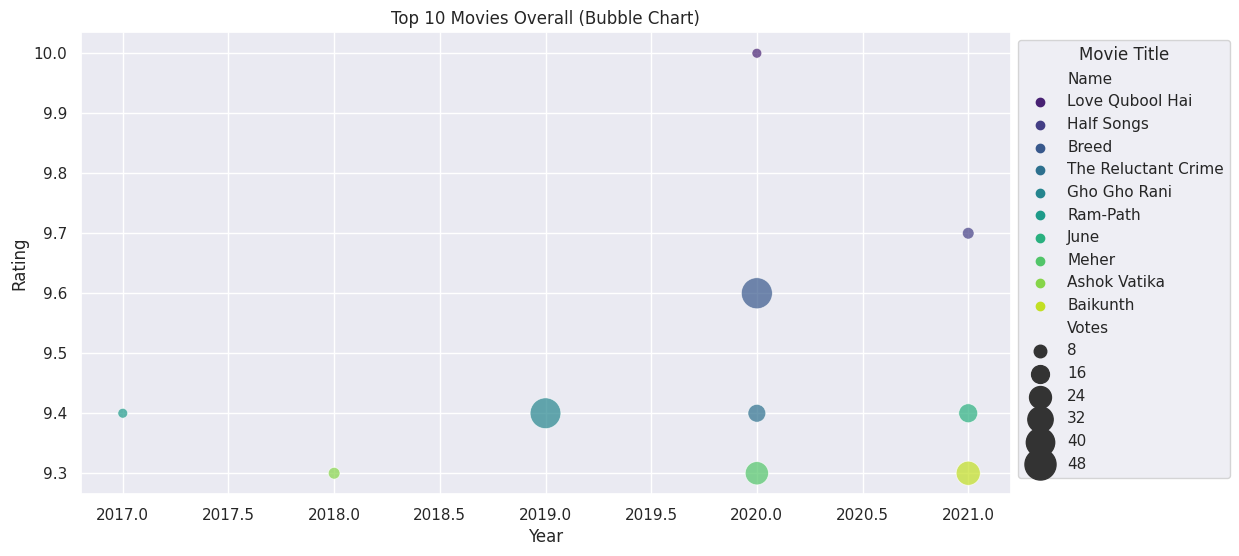

In [89]:
# Visualising the top rated movies per year will not be clear because of the large number of rows
# Trying to visualise the overall top rated movies based on the number of votes

plt.figure(figsize=(12, 6))
sns.scatterplot(x = 'Year', y = 'Rating', size = 'Votes', data = top_movies_overall, hue = 'Name', sizes = (50, 500), palette = 'viridis', alpha = 0.7)
plt.title('Top 10 Movies Overall (Bubble Chart)')
plt.xlabel('Year')
plt.ylabel('Rating')
plt.legend(bbox_to_anchor = (1, 1), loc = 'upper left', title = 'Movie Title')
plt.show()

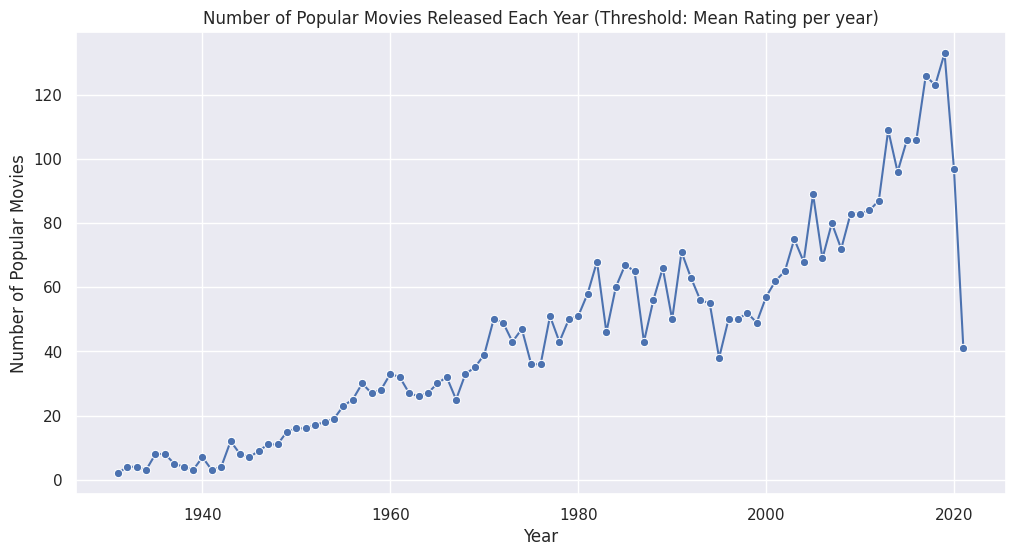

In [90]:
# Checking the number of popular movies each year
# We need to define what is popular
# We can see popular as the movies with a certain rating or above, but from the above explorations
# We know that some years had movies with low ratings
# Considering the mean rating of each year as the threshold for populariry
# We also cannot neglect the number of votes as even low rated movies can ve very polpular
# Decided to check movies based or rating and based on votes with same metrics of mean per year as threshold

mean_rating_per_year = filled_df.groupby('Year')['Rating'].mean().reset_index()

# Merge the mean popularity back into the original dataframe
mean_rated_df = pd.merge(filled_df, mean_rating_per_year, on = 'Year', suffixes=('', '_mean'))

# Use the mean popularity as the threshold
mean_rated_df['IsPopular_Rating'] = mean_rated_df['Rating'] > mean_rated_df['Rating_mean']

# Count the number of popular movies released each year
popular_rated_movies_count = mean_rated_df[mean_rated_df['IsPopular_Rating']].groupby('Year').size().reset_index(name = 'Number of Popular Movies (Rated)')

# Visualize the number of popular movies released each year using a line chart
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Number of Popular Movies (Rated)', data=popular_rated_movies_count, marker='o', color='b')
plt.title('Number of Popular Movies Released Each Year (Threshold: Mean Rating per year)')
plt.xlabel('Year')
plt.ylabel('Number of Popular Movies')
plt.grid(True)
plt.show()

In [91]:
print(popular_rated_movies_count)

    Year  Number of Popular Movies (Rated)
0   1931                                 2
1   1932                                 4
2   1933                                 4
3   1934                                 3
4   1935                                 8
..   ...                               ...
86  2017                               126
87  2018                               123
88  2019                               133
89  2020                                97
90  2021                                41

[91 rows x 2 columns]


In [97]:
mean_votes_per_year = filled_df.groupby('Year')['Votes'].mean().reset_index()

# Merge the mean popularity back into the original dataframe
mean_voted_df = pd.merge(filled_df, mean_votes_per_year, on = 'Year', suffixes=('', '_mean'))

# Use the mean popularity as the threshold
mean_voted_df['IsPopular_Voting'] = mean_voted_df['Votes'] > mean_voted_df['Votes_mean']

# Count the number of popular movies released each year
popular_voted_movies_count = mean_voted_df[mean_voted_df['IsPopular_Voting']].groupby('Year').size().reset_index(name = 'Number of Popular Movies (Voted)')

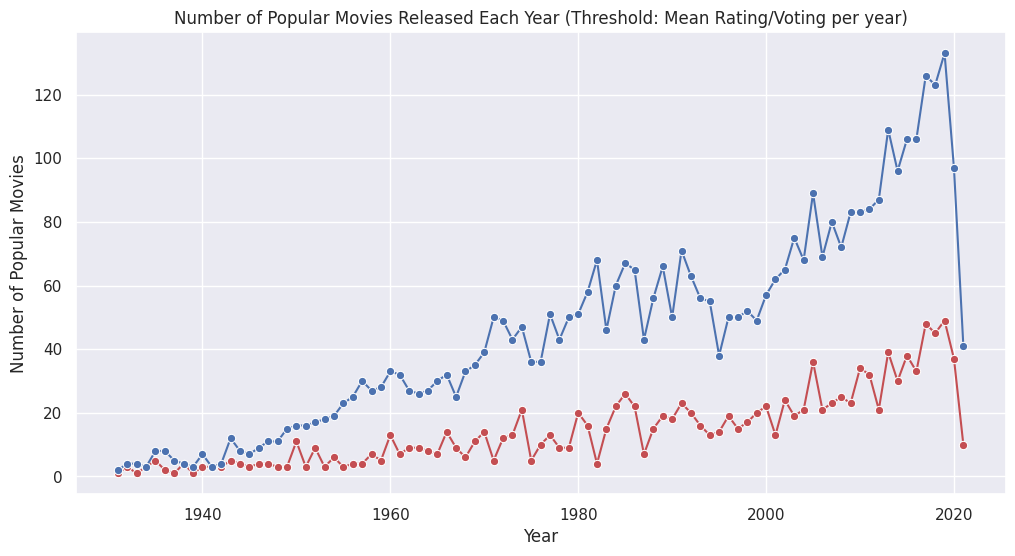

In [98]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Number of Popular Movies (Voted)', data=popular_voted_movies_count, marker='o', color='r')
sns.lineplot(x='Year', y='Number of Popular Movies (Rated)', data=popular_rated_movies_count, marker='o', color='b')
plt.title('Number of Popular Movies Released Each Year (Threshold: Mean Rating/Voting per year)')
plt.xlabel('Year')
plt.ylabel('Number of Popular Movies')
plt.grid(True)
plt.show()

In [99]:
# Find the maximum rating for each year
max_rating_per_year = filled_df.groupby('Year')['Rating'].max().reset_index()

# Merge the maximum rating back into the original dataframe
max_rated_df = pd.merge(filled_df, max_rating_per_year, on='Year', suffixes=('', '_max'))

# Count the number of votes for movies that performed better in rating each year
better_movies_votes_per_year = max_rated_df[max_rated_df['Rating'] == max_rated_df['Rating_max']].groupby('Year')['Votes'].sum().reset_index(name = 'Total Votes').sort_values(by = 'Year')

# Count the number of votes for movies that performed better in rating overall
better_movies_votes_overall = max_rated_df[max_rated_df['Rating'] == max_rated_df['Rating_max']].groupby('Name')['Votes'].sum().reset_index(name = 'Total Votes').sort_values(by = 'Total Votes', ascending = False)

print("Number of votes for movies that performed better in rating each year:")
print(better_movies_votes_per_year)

print("\nNumber of votes for movies that performed better in rating overall:")
print(better_movies_votes_overall)

Number of votes for movies that performed better in rating each year:
    Year  Total Votes
0   1917           22
1   1931          124
2   1932           12
3   1933           37
4   1934            6
..   ...          ...
87  2017            5
88  2018            7
89  2019           47
90  2020            5
91  2021            7

[92 rows x 2 columns]

Number of votes for movies that performed better in rating overall:
                           Name  Total Votes
0                      3 Idiots       357889
26           Gangs of Wasseypur        86355
18  Dilwale Dulhania Le Jayenge        65134
35                   Hera Pheri        59545
69             Paan Singh Tomar        34161
..                          ...          ...
59                      Mazdoor            6
87  Sant Ravidas Ki Amar Kahani            6
46                       Laadli            5
51              Love Qubool Hai            5
83                     Ram-Path            5

[106 rows x 2 columns]


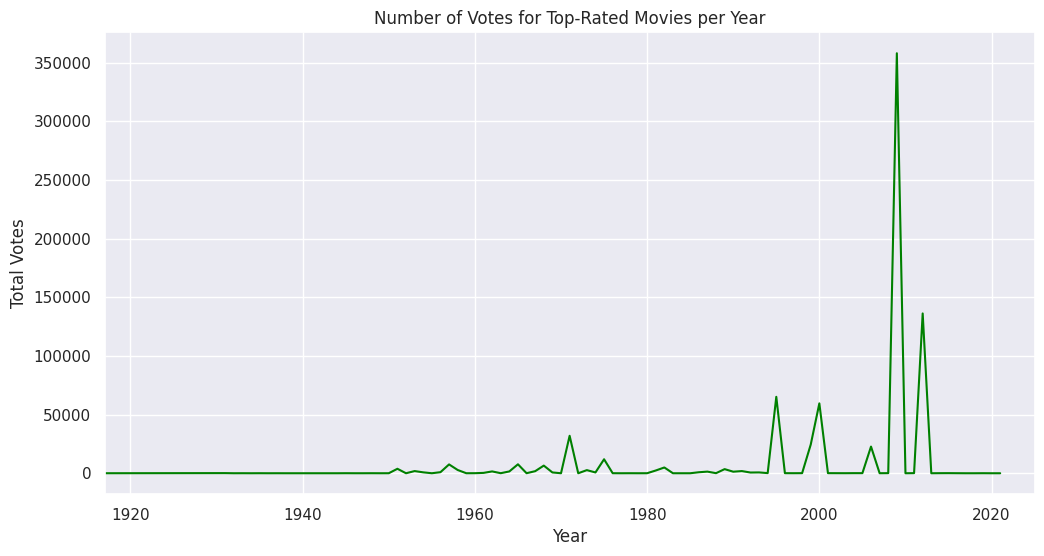

In [100]:
# Visualize the number of votes for movies that performed better in rating per year using a bar plot

plt.figure(figsize = (12, 6))
sns.lineplot(x = 'Year', y = 'Total Votes', data = better_movies_votes_per_year, color = 'green')
plt.title('Number of Votes for Top-Rated Movies per Year')
plt.ylabel('Total Votes')
plt.xlabel('Year')
plt.xlim(left = min(filled_df['Year']), right = 2025)
plt.show()

In [101]:
# Encoding all the object datatype variables

obj_list = train_df.select_dtypes(include = ['object']).columns.tolist()
print(obj_list)

['Name', 'Director', 'Actor 1', 'Actor 2', 'Actor 3', 'Genre']


In [102]:
# Checking the unique values in each object column to decide if we need to use them or not

for i in obj_list:
    print("Unique values in training dataset for %s column is: %s" % (i, train_df[i].nunique()))

Unique values in training dataset for Name column is: 5612
Unique values in training dataset for Director column is: 2624
Unique values in training dataset for Actor 1 column is: 2104
Unique values in training dataset for Actor 2 column is: 2386
Unique values in training dataset for Actor 3 column is: 2567
Unique values in training dataset for Genre column is: 20


In [103]:
# Checking the percantage of unique values in each object column to decide if we need to use them or not

for i in obj_list:
    print("Percentage of unique values in training dataset for %s column is: %s percent" % (i, train_df[i].nunique() / len(train_df) * 100))

Percentage of unique values in training dataset for Name column is: 94.49402256272099 percent
Percentage of unique values in training dataset for Director column is: 44.182522310153225 percent
Percentage of unique values in training dataset for Actor 1 column is: 35.4268395352753 percent
Percentage of unique values in training dataset for Actor 2 column is: 40.175113655497555 percent
Percentage of unique values in training dataset for Actor 3 column is: 43.222764775214685 percent
Percentage of unique values in training dataset for Genre column is: 0.3367570298029971 percent


In [104]:
train_df.head(2)

,Name,Year,Duration,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Genre
11500,Rahi,1953,139.0,7.0,28,Khwaja Ahmad Abbas,Dev Anand,Nalini Jaywant,Balraj Sahni,Drama
5167,Gooli,2008,138.0,6.4,80,P. Satya,Sudeep,Mamta Mohandas,Kishore Kumar G.,Action


In [105]:
# Droping the insignificant variables

train_df = train_df.drop(['Name'], axis = 1)
validation_df = validation_df.drop(['Name'], axis = 1)

train_df.head(2)

,Year,Duration,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Genre
11500,1953,139.0,7.0,28,Khwaja Ahmad Abbas,Dev Anand,Nalini Jaywant,Balraj Sahni,Drama
5167,2008,138.0,6.4,80,P. Satya,Sudeep,Mamta Mohandas,Kishore Kumar G.,Action


In [106]:
validation_df.head(2)

,Year,Duration,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Genre
12679,2018,104.0,6.8,1117,Harish Vyas,Shivani Raghuvanshi,Anshuman Jha,Ekavali Khanna,Drama
12294,1998,126.0,7.5,31,Shyam Benegal,Rajeshwari Sachdev,Rajit Kapoor,Ravi Jhankal,Drama


In [107]:
# Using Target encoding to encode the categorical variables
# As there are a diverese range of categorical variables

categorical_variables = train_df.select_dtypes(include = ['object']).columns.tolist()
encoder = ce.TargetEncoder(cols = categorical_variables)
encoded_df = encoder.fit_transform(train_df[categorical_variables], train_df['Rating'])

In [108]:
encoded_df.columns = [f"{col}_TargetEncoded" for col in categorical_variables]
train_df = pd.concat([train_df, encoded_df], axis = 1)
train_df.head(2)

,Year,Duration,Rating,Votes,Director,Actor 1,Actor 2,Actor 3,Genre,Director_TargetEncoded,Actor 1_TargetEncoded,Actor 2_TargetEncoded,Actor 3_TargetEncoded,Genre_TargetEncoded
11500,1953,139.0,7.0,28,Khwaja Ahmad Abbas,Dev Anand,Nalini Jaywant,Balraj Sahni,Drama,5.998386,6.831455,5.865679,6.167203,6.185942
5167,2008,138.0,6.4,80,P. Satya,Sudeep,Mamta Mohandas,Kishore Kumar G.,Action,5.929491,5.877261,5.872009,5.929491,5.437335


In [109]:
# Droping the categorical variables and keeping the encoded columns

train_df = train_df.drop(['Director', 'Actor 1', 'Actor 2', 'Actor 3', 'Genre'], axis = 1)
train_df.head(2)

,Year,Duration,Rating,Votes,Director_TargetEncoded,Actor 1_TargetEncoded,Actor 2_TargetEncoded,Actor 3_TargetEncoded,Genre_TargetEncoded
11500,1953,139.0,7.0,28,5.998386,6.831455,5.865679,6.167203,6.185942
5167,2008,138.0,6.4,80,5.929491,5.877261,5.872009,5.929491,5.437335


In [110]:
# Traget encoding the validation df

encoded_val_df = encoder.fit_transform(validation_df[categorical_variables], validation_df['Rating'])
encoded_val_df.columns = [f"{col}_TargetEncoded" for col in categorical_variables]
validation_df = pd.concat([validation_df, encoded_val_df], axis = 1)
validation_df = validation_df.drop(['Director', 'Actor 1', 'Actor 2', 'Actor 3', 'Genre'], axis = 1)

In [111]:
validation_df.head(2)

,Year,Duration,Rating,Votes,Director_TargetEncoded,Actor 1_TargetEncoded,Actor 2_TargetEncoded,Actor 3_TargetEncoded,Genre_TargetEncoded
12679,2018,104.0,6.8,1117,5.920663,5.920663,5.953810,5.920663,6.134947
12294,1998,126.0,7.5,31,6.067291,6.011739,6.011739,6.011739,6.134947


In [112]:
train_df.shape

(5939, 9)

In [113]:
validation_df.shape

(1980, 9)

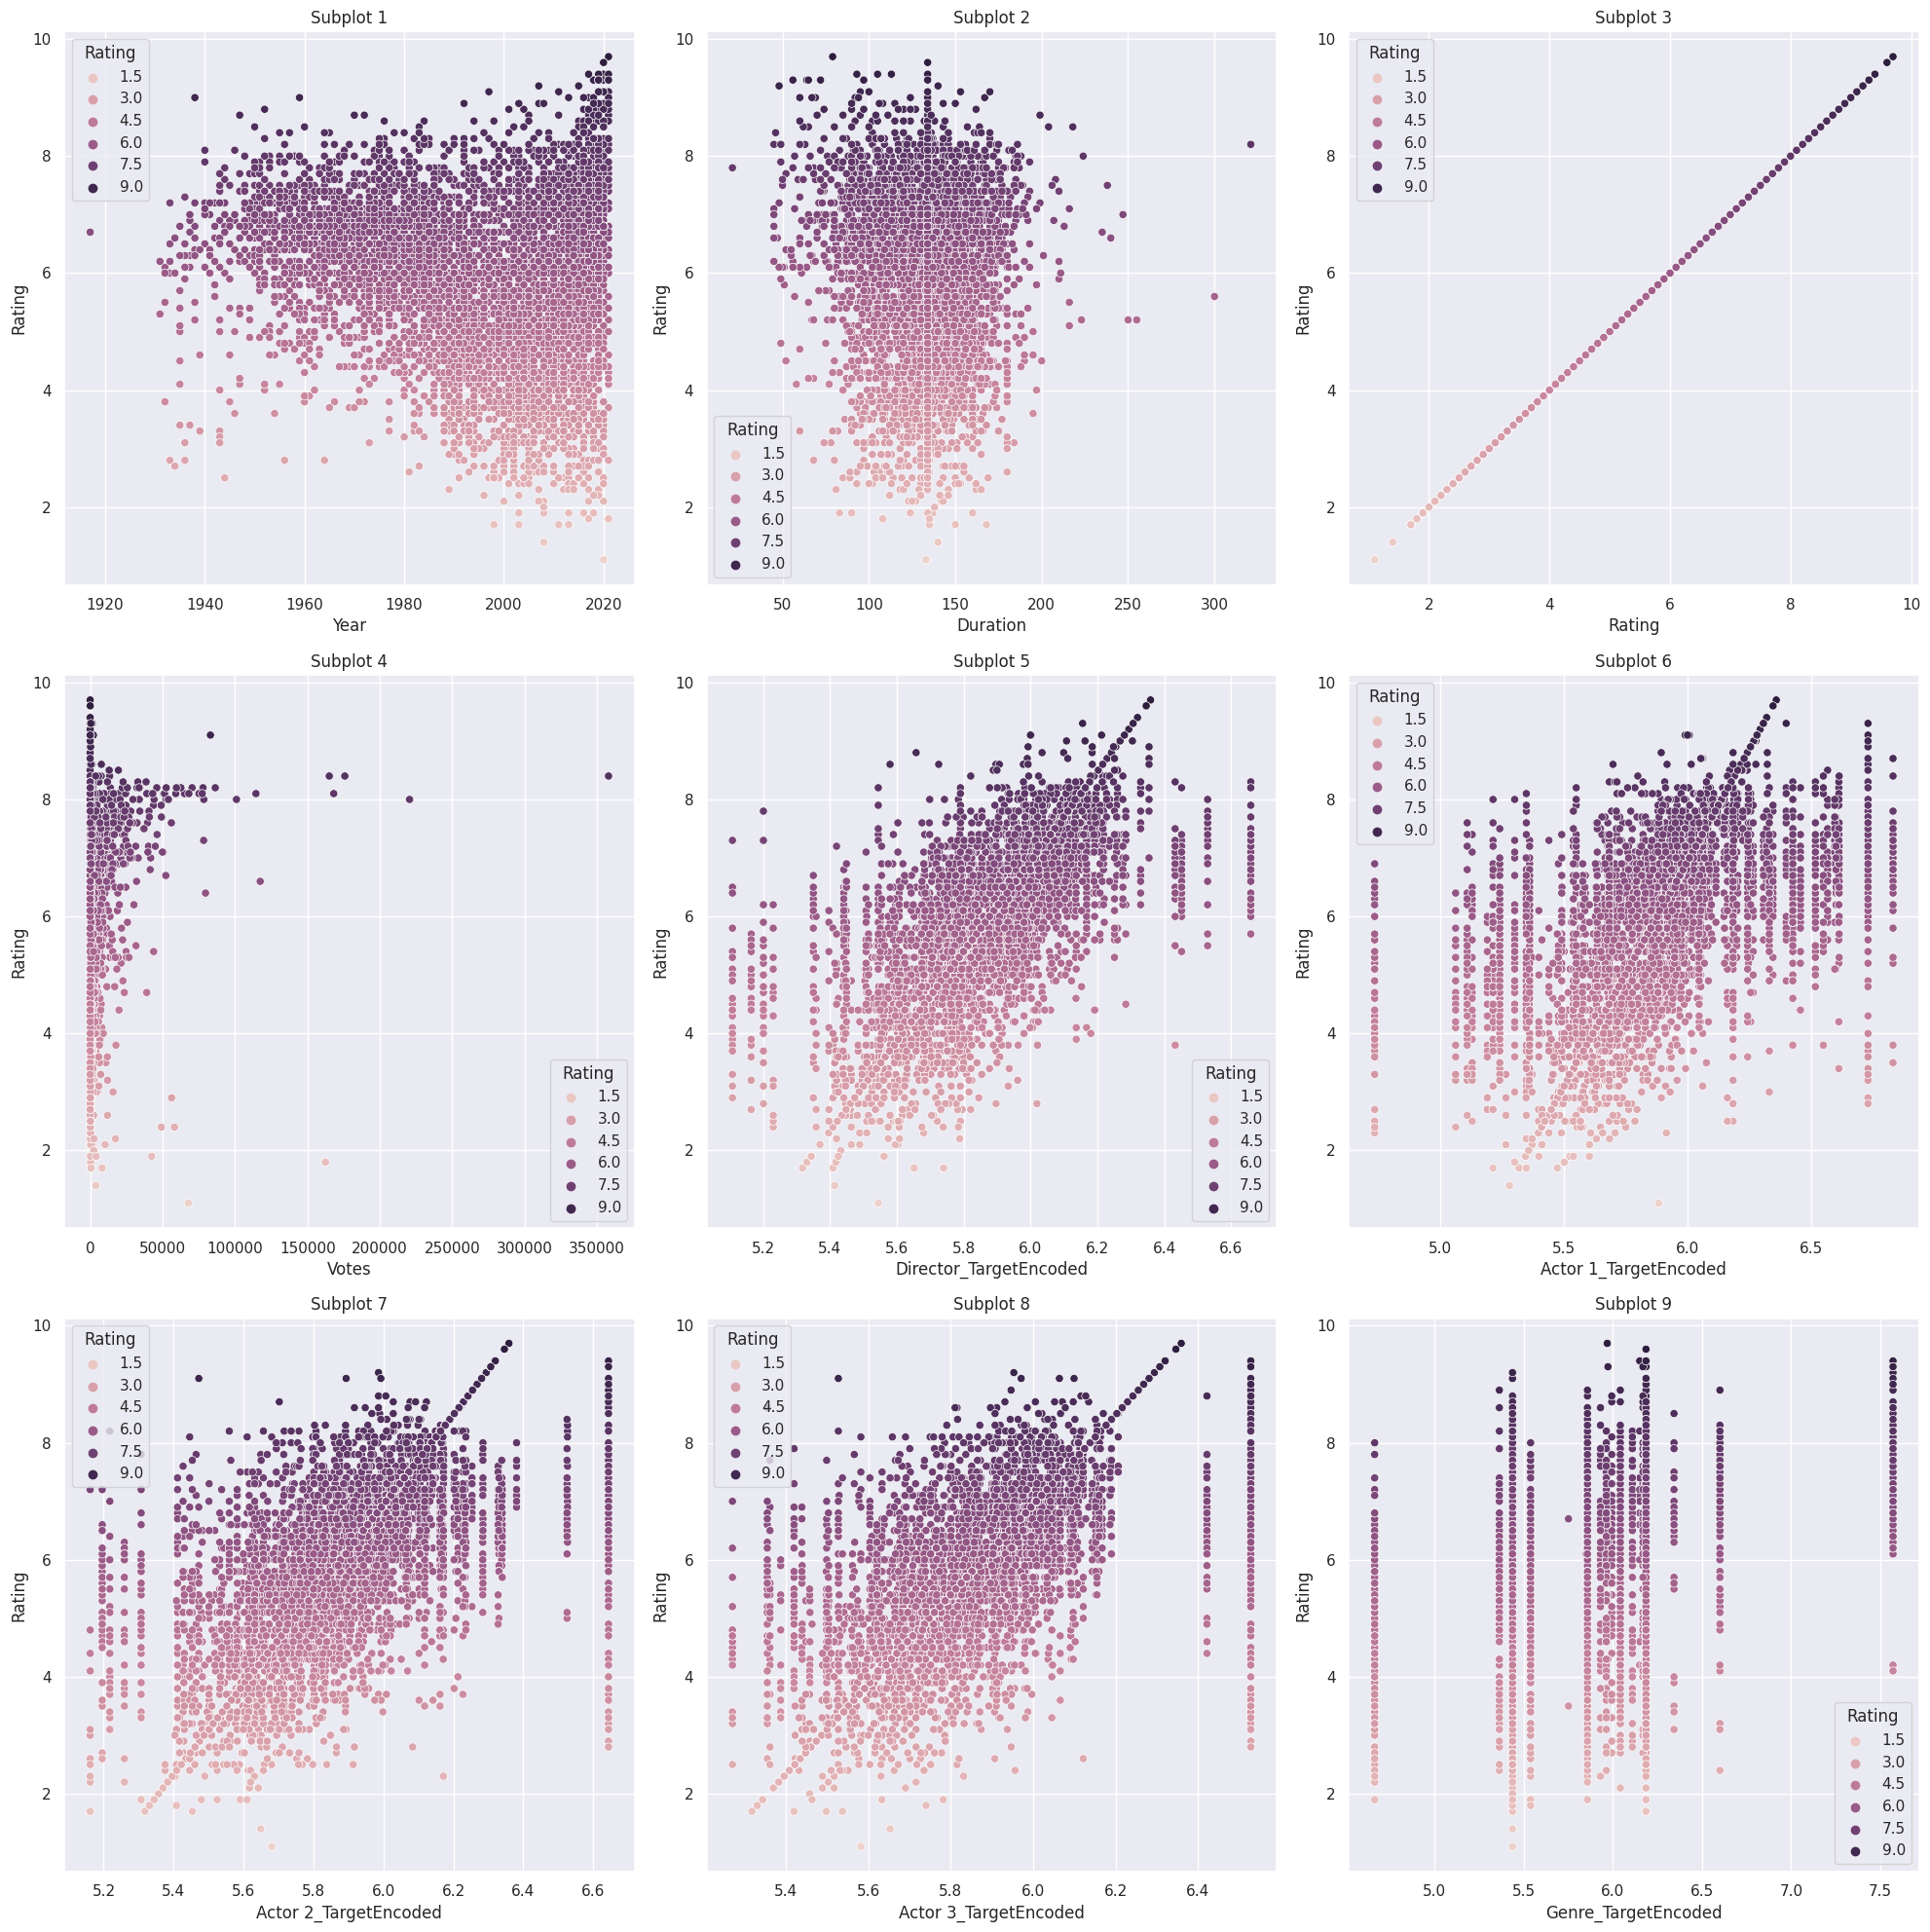

In [114]:
# Exploratory data analysis
# Exploring the signficance of every variable
# Visualising the data to understand the significance
# Create a scatter plot with points colored by the 'Rating' column

numeric_cols = train_df.select_dtypes(include = np.number)
col_names = list(numeric_cols.columns)
col_index = 0
plt_rows = 3
plt_cols = 3

fig, ax = plt.subplots(nrows = plt_rows, ncols = plt_cols, figsize = (20, 20))
ax = ax.flatten()

for i, ax in enumerate(ax):
#     for col_count in range(plt_cols):
#         ax[row_count][col_count].scatterplot(y = train_df[col_names[col_index]], x = train_df.index, hue = "Rating")
#         ax[row_count][col_count].set_ylabel(col_names[col_index])
#         col_index += 1
    sns.scatterplot(x = train_df[col_names[col_index]], y = train_df['Rating'], data = train_df, hue = "Rating", ax = ax)
    ax.set_title(f'Subplot {i+1}')
    col_index += 1

plt.tight_layout()
plt.show()

In [115]:
# Splitting dependent and independent variable

raw_x_train = train_df.drop(['Rating'], axis = 1)
raw_y_train = train_df['Rating']

raw_x_val = validation_df.drop(['Rating'], axis = 1)
raw_y_val = validation_df['Rating']

raw_x_train.head(2)

,Year,Duration,Votes,Director_TargetEncoded,Actor 1_TargetEncoded,Actor 2_TargetEncoded,Actor 3_TargetEncoded,Genre_TargetEncoded
11500,1953,139.0,28,5.998386,6.831455,5.865679,6.167203,6.185942
5167,2008,138.0,80,5.929491,5.877261,5.872009,5.929491,5.437335


In [116]:
raw_x_val.head(2)

,Year,Duration,Votes,Director_TargetEncoded,Actor 1_TargetEncoded,Actor 2_TargetEncoded,Actor 3_TargetEncoded,Genre_TargetEncoded
12679,2018,104.0,1117,5.920663,5.920663,5.953810,5.920663,6.134947
12294,1998,126.0,31,6.067291,6.011739,6.011739,6.011739,6.134947


In [117]:
# Building the models

# Linear Regression model
linear_model_raw = LinearRegression()
linear_model_raw.fit(raw_x_train, raw_y_train)
raw_y_pred_train_lr = linear_model_raw.predict(raw_x_train)
raw_y_pred_val_lr = linear_model_raw.predict(raw_x_val)

print("Accuracy Scores for Linear Regression model on raw data")
raw_lr_rmse = mean_squared_error(raw_y_val, raw_y_pred_val_lr)
raw_train_lr_r2s = r2_score(raw_y_train, raw_y_pred_train_lr)
raw_val_lr_r2s = r2_score(raw_y_val, raw_y_pred_val_lr)
print("Mean Squared Error :", raw_lr_rmse)
print("R-squared Score (Train) :", raw_train_lr_r2s)
print("R-squared Score (Test) :", raw_val_lr_r2s)
print("**************" * 7)

# Lasso Regression (L1 Regularization) going with alpha = 0.05, after checking various values
lasso_model_raw = Lasso(alpha = 0.05)
lasso_model_raw.fit(raw_x_train, raw_y_train)
raw_y_pred_train_lar = lasso_model_raw.predict(raw_x_train)
raw_y_pred_val_lar = lasso_model_raw.predict(raw_x_val)

print("Accuracy Scores for Lasso Regression (L1 Regularization) model on raw data")
raw_lar_rmse = mean_squared_error(raw_y_val, raw_y_pred_val_lar)
raw_train_lar_r2s = r2_score(raw_y_train, raw_y_pred_train_lar)
raw_val_lar_r2s = r2_score(raw_y_val, raw_y_pred_val_lar)
print("Mean Squared Error :", raw_lar_rmse)
print("R-squared Score (Train) :", raw_train_lar_r2s)
print("R-squared Score (Test) :", raw_val_lar_r2s)
print("**************" * 7)

# Ridge Regression (L2 Regularization) going with alpha = 0.05, after checking various values
ridge_model_raw = Ridge(alpha = 0.05)
ridge_model_raw.fit(raw_x_train, raw_y_train)
raw_y_pred_train_ridge = ridge_model_raw.predict(raw_x_train)
raw_y_pred_val_ridge = ridge_model_raw.predict(raw_x_val)

print("Accuracy Scores for Ridge Regression (L2 Regularization) model on raw data")
raw_ridge_rmse = mean_squared_error(raw_y_val, raw_y_pred_val_ridge)
raw_train_ridge_r2s = r2_score(raw_y_train, raw_y_pred_train_ridge)
raw_val_ridge_r2s = r2_score(raw_y_val, raw_y_pred_val_ridge)
print("Mean Squared Error :", raw_ridge_rmse)
print("R-squared Score (Train) :", raw_train_ridge_r2s)
print("R-squared Score (Test) :", raw_val_ridge_r2s)
print("**************" * 7)

# Elastic Net Regression (L1 and L2 Regularizations) going with alpha = 0.05, after checking various values
enet_model_raw = ElasticNet(alpha = 0.05, random_state = 101)
enet_model_raw.fit(raw_x_train, raw_y_train)
raw_y_pred_train_enet = enet_model_raw.predict(raw_x_train)
raw_y_pred_val_enet = enet_model_raw.predict(raw_x_val)

print("Accuracy Scores for Elastic Net Regression (L1 and L2 Regularizations) model on raw data")
raw_enet_rmse = mean_squared_error(raw_y_val, raw_y_pred_val_enet)
raw_train_enet_r2s = r2_score(raw_y_train, raw_y_pred_train_enet)
raw_val_enet_r2s = r2_score(raw_y_val, raw_y_pred_val_enet)
print("Mean Squared Error :", raw_enet_rmse)
print("R-squared Score (Train) :", raw_train_enet_r2s)
print("R-squared Score (Test) :", raw_val_enet_r2s)
print("**************" * 7)

# Decission Tree regression - Choosing max depth as 6 after trying different values
dtree_raw = DecisionTreeRegressor(max_depth = 6)
dtree_raw.fit(raw_x_train, raw_y_train)
raw_y_pred_train_dtree = dtree_raw.predict(raw_x_train)
raw_y_pred_val_dtree = dtree_raw.predict(raw_x_val)

print("Accuracy Scores for Decision Tree model on raw data")
raw_dtree_rmse = mean_squared_error(raw_y_val, raw_y_pred_val_dtree)
raw_train_dtree_r2s = r2_score(raw_y_train, raw_y_pred_train_dtree)
raw_val_dtree_r2s = r2_score(raw_y_val, raw_y_pred_val_dtree)
print("Mean Squared Error :", raw_dtree_rmse)
print("R-squared Score (Train) :", raw_train_dtree_r2s)
print("R-squared Score (Test) :", raw_val_dtree_r2s)
print("**************" * 7)

# Random Forest regression - Choosing max depth as 6 after trying different values
# Choosing the parameters after trying different values
rf_raw = RandomForestRegressor(n_estimators = 100, random_state = 1, max_depth = 6)
rf_raw.fit(raw_x_train, raw_y_train)
raw_y_pred_train_rf = rf_raw.predict(raw_x_train)
raw_y_pred_val_rf = rf_raw.predict(raw_x_val)

print("Accuracy Scores for Random Forest model on raw data")
raw_rf_rmse = mean_squared_error(raw_y_val, raw_y_pred_val_rf)
raw_train_rf_r2s = r2_score(raw_y_train, raw_y_pred_train_rf)
raw_val_rf_r2s = r2_score(raw_y_val, raw_y_pred_val_rf)
print("Mean Squared Error :", raw_rf_rmse)
print("R-squared Score (Train) :", raw_train_rf_r2s)
print("R-squared Score (Test) :", raw_val_rf_r2s)
print("**************" * 7)

# Gradient Boosting Regression model
gb_raw = GradientBoostingRegressor(n_estimators = 100, max_depth = 3, random_state = 123)
gb_raw.fit(raw_x_train, raw_y_train)
raw_y_pred_train_gb = gb_raw.predict(raw_x_train)
raw_y_pred_val_gb = gb_raw.predict(raw_x_val)

print("Accuracy Scores for Gradient Boost Regressor model on raw data")
raw_gb_rmse = mean_squared_error(raw_y_val, raw_y_pred_val_gb)
raw_train_gb_r2s = r2_score(raw_y_train, raw_y_pred_train_gb)
raw_val_gb_r2s = r2_score(raw_y_val, raw_y_pred_val_gb)
print("Mean Squared Error :", raw_gb_rmse)
print("R-squared Score (Train) :", raw_train_gb_r2s)
print("R-squared Score (Test) :", raw_val_gb_r2s)
print("**************" * 7)

# LGBoost Regression model - Max depth and Num_leaves = 3 after testing various values
lgb_raw = lgb.LGBMRegressor(random_state = 11, max_depth = 3, num_leaves = 3, force_col_wise = True)
lgb_raw.fit(raw_x_train, raw_y_train)
raw_y_pred_train_lgb = lgb_raw.predict(raw_x_train)
raw_y_pred_val_lgb = lgb_raw.predict(raw_x_val)

print("Accuracy Scores for LGBoost model on raw data")
raw_lgb_rmse = mean_squared_error(raw_y_val, raw_y_pred_val_lgb)
raw_train_lgb_r2s = r2_score(raw_y_train, raw_y_pred_train_lgb)
raw_val_lgb_r2s = r2_score(raw_y_val, raw_y_pred_val_lgb)
print("Mean Squared Error :", raw_lgb_rmse)
print("R-squared Score (Train) :", raw_train_lgb_r2s)
print("R-squared Score (Test) :", raw_val_lgb_r2s)
print("**************" * 7)

# XGBoost Regression model - Max depth = 2 after testing various values
xgb_raw = xgb.XGBRegressor(random_state = 111, max_depth = 2)
xgb_raw.fit(raw_x_train, raw_y_train)
raw_y_pred_train_xgb = xgb_raw.predict(raw_x_train)
raw_y_pred_val_xgb = xgb_raw.predict(raw_x_val)

print("Accuracy Scores for XGBoost model on raw data")
raw_xgb_rmse = mean_squared_error(raw_y_val, raw_y_pred_val_xgb)
raw_train_xgb_r2s = r2_score(raw_y_train, raw_y_pred_train_xgb)
raw_val_xgb_r2s = r2_score(raw_y_val, raw_y_pred_val_xgb)
print("Mean Squared Error :", raw_xgb_rmse)
print("R-squared Score (Train) :", raw_train_xgb_r2s)
print("R-squared Score (Test) :", raw_val_xgb_r2s)
print("**************" * 7)

Accuracy Scores for Linear Regression model on raw data
Mean Squared Error : 0.6152699339643991
R-squared Score (Train) : 0.6143316167103741
R-squared Score (Test) : 0.6735125722222858
**************************************************************************************************
Accuracy Scores for Lasso Regression (L1 Regularization) model on raw data
Mean Squared Error : 0.7528051929252879
R-squared Score (Train) : 0.5779444431898935
R-squared Score (Test) : 0.6005307305165595
**************************************************************************************************
Accuracy Scores for Ridge Regression (L2 Regularization) model on raw data
Mean Squared Error : 0.6153056264127577
R-squared Score (Train) : 0.6143316105121559
R-squared Score (Test) : 0.6734936323472612
**************************************************************************************************
Accuracy Scores for Elastic Net Regression (L1 and L2 Regularizations) model on raw data
Mean Squared Error : 

In [118]:
# Function to find the best value of K based on mean squared error

def find_k(x_train, y_train, x_test, y_test):
    error_rate = []    # Finding the error rate for 50 iterations

    for i in range(1, 50):
        knn = KNeighborsRegressor(n_neighbors = i)    # Building the model with i neighbors
        knn.fit(x_train, y_train)
        y_pred = knn.predict(x_test)
        error_rate.append(mean_squared_error(y_test, y_pred))

# Ploting the error values to find the best value of k

    plt.figure(figsize = (8, 8))
    plt.plot(range(1,50), error_rate, color = 'red', linestyle = 'dashed', marker = 'o', markersize = 10, markerfacecolor = 'blue')
    plt.title("Mean Squared Error vs K-Value")
    plt.xlabel("K-Value")
    plt.ylabel("Mean Squared Error")
    plt.show()

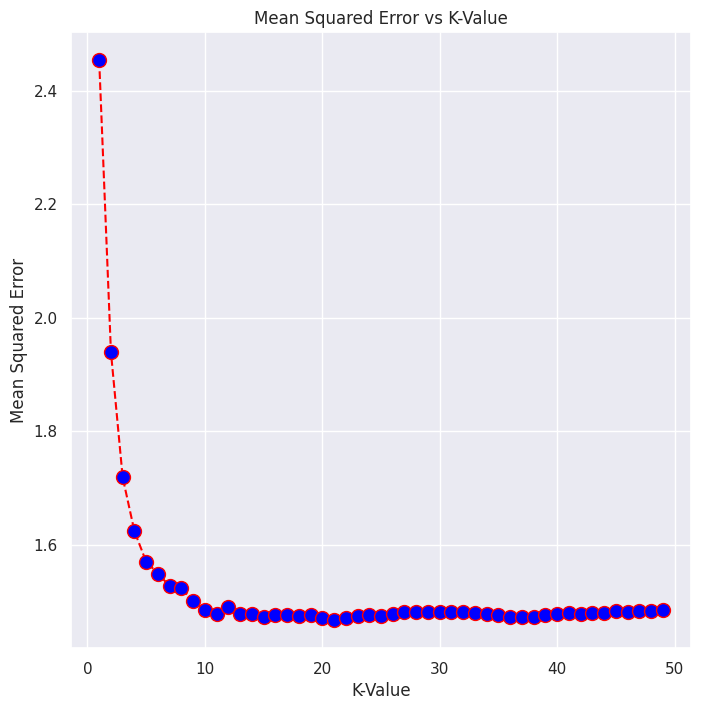

In [119]:
find_k(raw_x_train, raw_y_train, raw_x_val, raw_y_val)

In [120]:
# Building KNN regressor with k = 11
knn_raw = KNeighborsRegressor(n_neighbors = 11)
knn_raw.fit(raw_x_train, raw_y_train)
raw_y_pred_train_knn = knn_raw.predict(raw_x_train)
raw_y_pred_val_knn = knn_raw.predict(raw_x_val)

print("Accuracy Scores for KNN Regressor model on raw data")
raw_knn_rmse = mean_squared_error(raw_y_val, raw_y_pred_val_knn)
raw_train_knn_r2s = r2_score(raw_y_train, raw_y_pred_train_knn)
raw_val_knn_r2s = r2_score(raw_y_val, raw_y_pred_val_knn)
print("Mean Squared Error :", raw_knn_rmse)
print("R-squared Score (Train) :", raw_train_knn_r2s)
print("R-squared Score (Test) :", raw_val_knn_r2s)
print("**************" * 7)

Accuracy Scores for KNN Regressor model on raw data
Mean Squared Error : 1.477971533516988
R-squared Score (Train) : 0.33046720097840265
R-squared Score (Test) : 0.21572776813994943
**************************************************************************************************


In [121]:
# Function for checking the best model out of the tested models for correlation treated dataset

def check_scores(mse_list, r2_train_list, r2_test_list, data):
    models_list = ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'Elastic Net Regression', "Decission Tree Regression",
                   'Random Forest Regression', 'Gradient Boosting Regression', 'LGBoost Regression', 'XGBoost Regression',
                   'K Nearest Neighbour', 'SVR - Linear', 'SVR - Polynomial', 'SVR - Sigmoid', 'SVR - RBF']

    accuracy = pd.DataFrame({'Method' : models_list, 'Mean Squared Error' : mse_list, 'R2Score(Training)' : r2_train_list,
                           'R2Score(Testing)' : r2_test_list})

    sns.lineplot(x = 'Method', y = 'Mean Squared Error', data = accuracy, label = 'MSE', color = 'green', linestyle = 'dashed', marker = 'o', markersize = 5, markerfacecolor = 'green')
    sns.lineplot(x = 'Method', y = 'R2Score(Training)', data = accuracy, label = 'R2Train', color = 'blue', linestyle = 'dashed', marker = 'o', markersize = 5, markerfacecolor = 'blue')
    sns.lineplot(x = 'Method', y = 'R2Score(Testing)', data = accuracy, label = 'R2Test', color = 'brown', linestyle = 'dashed', marker = 'o', markersize = 5, markerfacecolor = 'brown')
    plt.xticks(rotation = 90)
    plt.title("Accuracy on %s dataset" % data)
    plt.ylim(0.0, 1.0)
    plt.axhline(y = 0.7, linewidth = 1, color = 'red')
    plt.show()

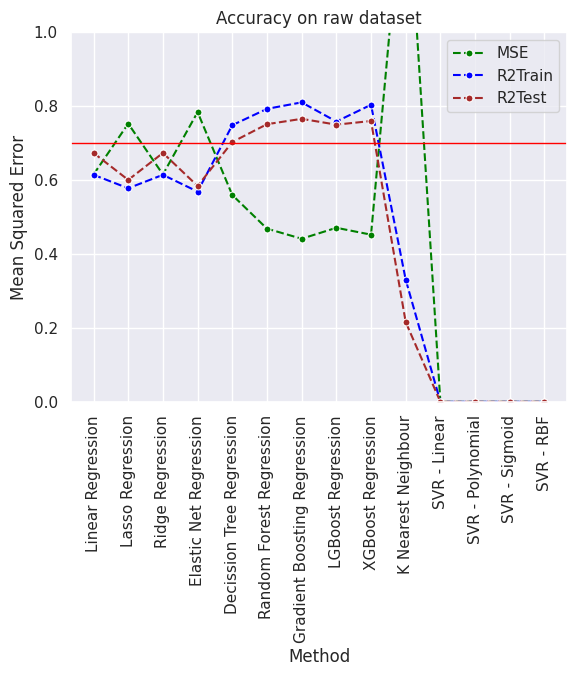

In [122]:
# Checking the accuracy of models on raw data

raw_mse_list = [raw_lr_rmse, raw_lar_rmse, raw_ridge_rmse, raw_enet_rmse, raw_dtree_rmse, raw_rf_rmse, raw_gb_rmse, raw_lgb_rmse,
                raw_xgb_rmse, raw_knn_rmse, 0, 0, 0, 0]

raw_r2_train_list = [raw_train_lr_r2s, raw_train_lar_r2s, raw_train_ridge_r2s, raw_train_enet_r2s, raw_train_dtree_r2s,
                    raw_train_rf_r2s, raw_train_gb_r2s, raw_train_lgb_r2s, raw_train_xgb_r2s, raw_train_knn_r2s, 0, 0, 0, 0]

raw_r2_test_list = [raw_val_lr_r2s, raw_val_lar_r2s, raw_val_ridge_r2s, raw_val_enet_r2s, raw_val_dtree_r2s, raw_val_rf_r2s,
                   raw_val_gb_r2s, raw_val_lgb_r2s, raw_val_xgb_r2s, raw_val_knn_r2s, 0, 0, 0, 0]

check_scores(raw_mse_list, raw_r2_train_list, raw_r2_test_list, 'raw')

#### Handling outliers to see if accuracy can be improved

In [123]:
# Checking for outliers

olt_x_train = raw_x_train
olt_y_train = train_df['Rating']

olt_x_val = raw_x_val
olt_y_val = validation_df['Rating']

olt_x_train.head(2)

,Year,Duration,Votes,Director_TargetEncoded,Actor 1_TargetEncoded,Actor 2_TargetEncoded,Actor 3_TargetEncoded,Genre_TargetEncoded
11500,1953,139.0,28,5.998386,6.831455,5.865679,6.167203,6.185942
5167,2008,138.0,80,5.929491,5.877261,5.872009,5.929491,5.437335


In [124]:
olt_x_val.head(2)

,Year,Duration,Votes,Director_TargetEncoded,Actor 1_TargetEncoded,Actor 2_TargetEncoded,Actor 3_TargetEncoded,Genre_TargetEncoded
12679,2018,104.0,1117,5.920663,5.920663,5.953810,5.920663,6.134947
12294,1998,126.0,31,6.067291,6.011739,6.011739,6.011739,6.134947


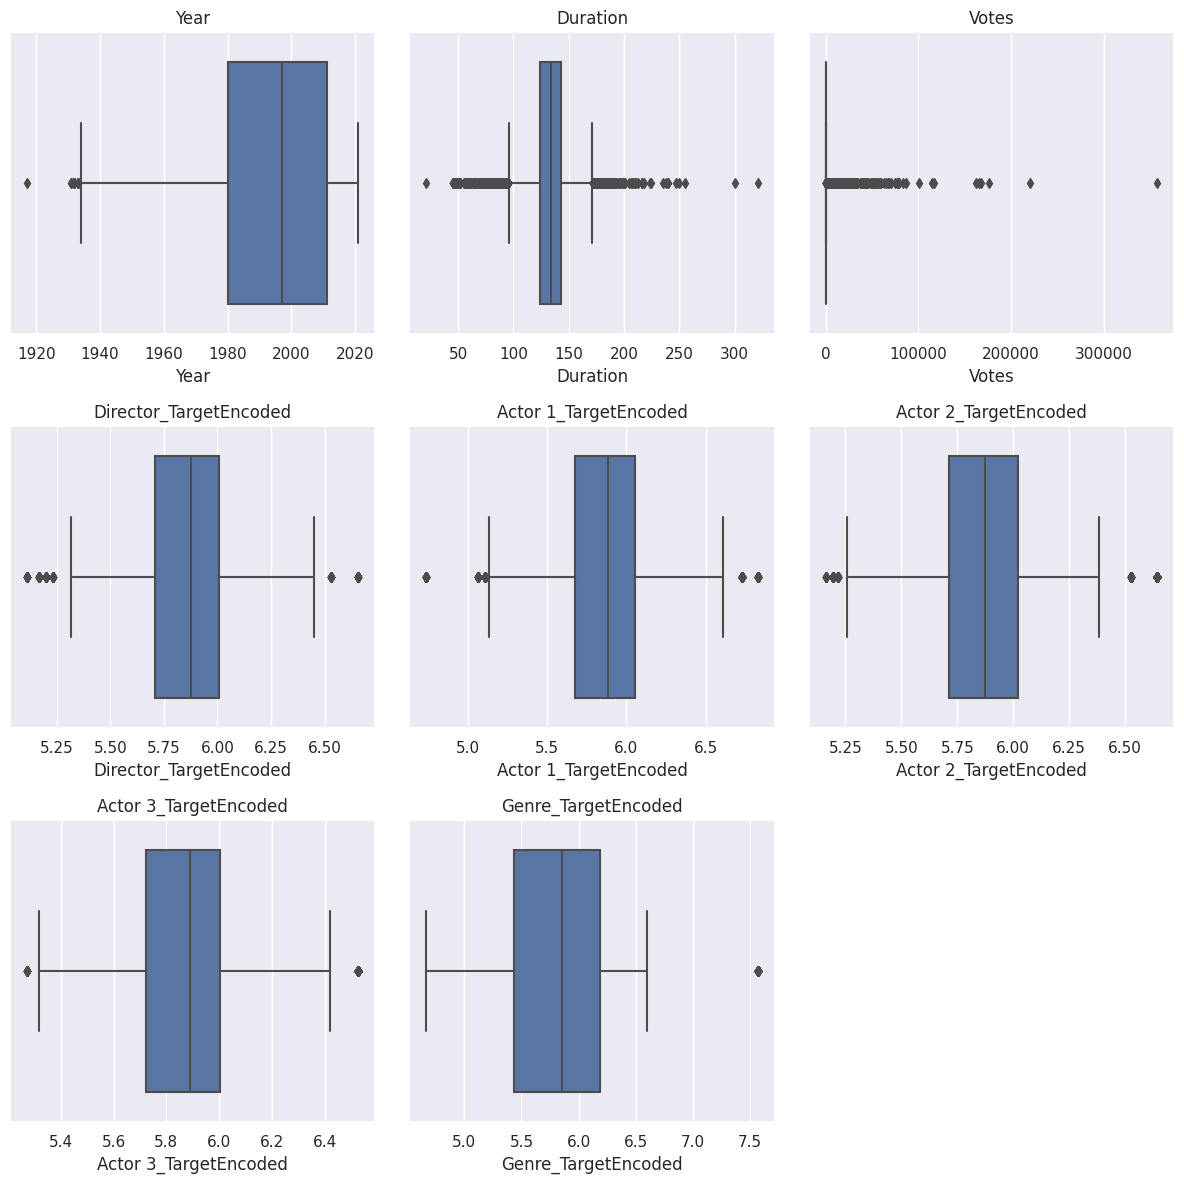

In [125]:
# Checking for outliers using boxplots

plt.figure(figsize=(12, 12))

for col in olt_x_train.select_dtypes(include=['number']).columns:
    plt.subplot(3, 3, olt_x_train.columns.get_loc(col) + 1)  # Adjust the subplot layout as needed
    sns.boxplot(x=olt_x_train[col])
    plt.title(col)

plt.tight_layout()
plt.show()

In [126]:
# Outlier treatment

out_list = ['Duration', 'Votes', 'Director_TargetEncoded', 'Actor 1_TargetEncoded', 'Actor 2_TargetEncoded',
            'Actor 3_TargetEncoded', 'Genre_TargetEncoded']

for i in olt_x_train.columns:
    col_q1 = olt_x_train[i].quantile(0.25)
    col_q3 = olt_x_train[i].quantile(0.75)
    col_iqr = col_q3 - col_q1

    upper_limit = col_q3 + (1.5 * col_iqr)
    lower_limit = col_q1 - (1.5 * col_iqr)

    if i in out_list:
        olt_x_train[i] = np.where(olt_x_train[i] > upper_limit, upper_limit,
                                   np.where(olt_x_train[i] < lower_limit, lower_limit, olt_x_train[i]))

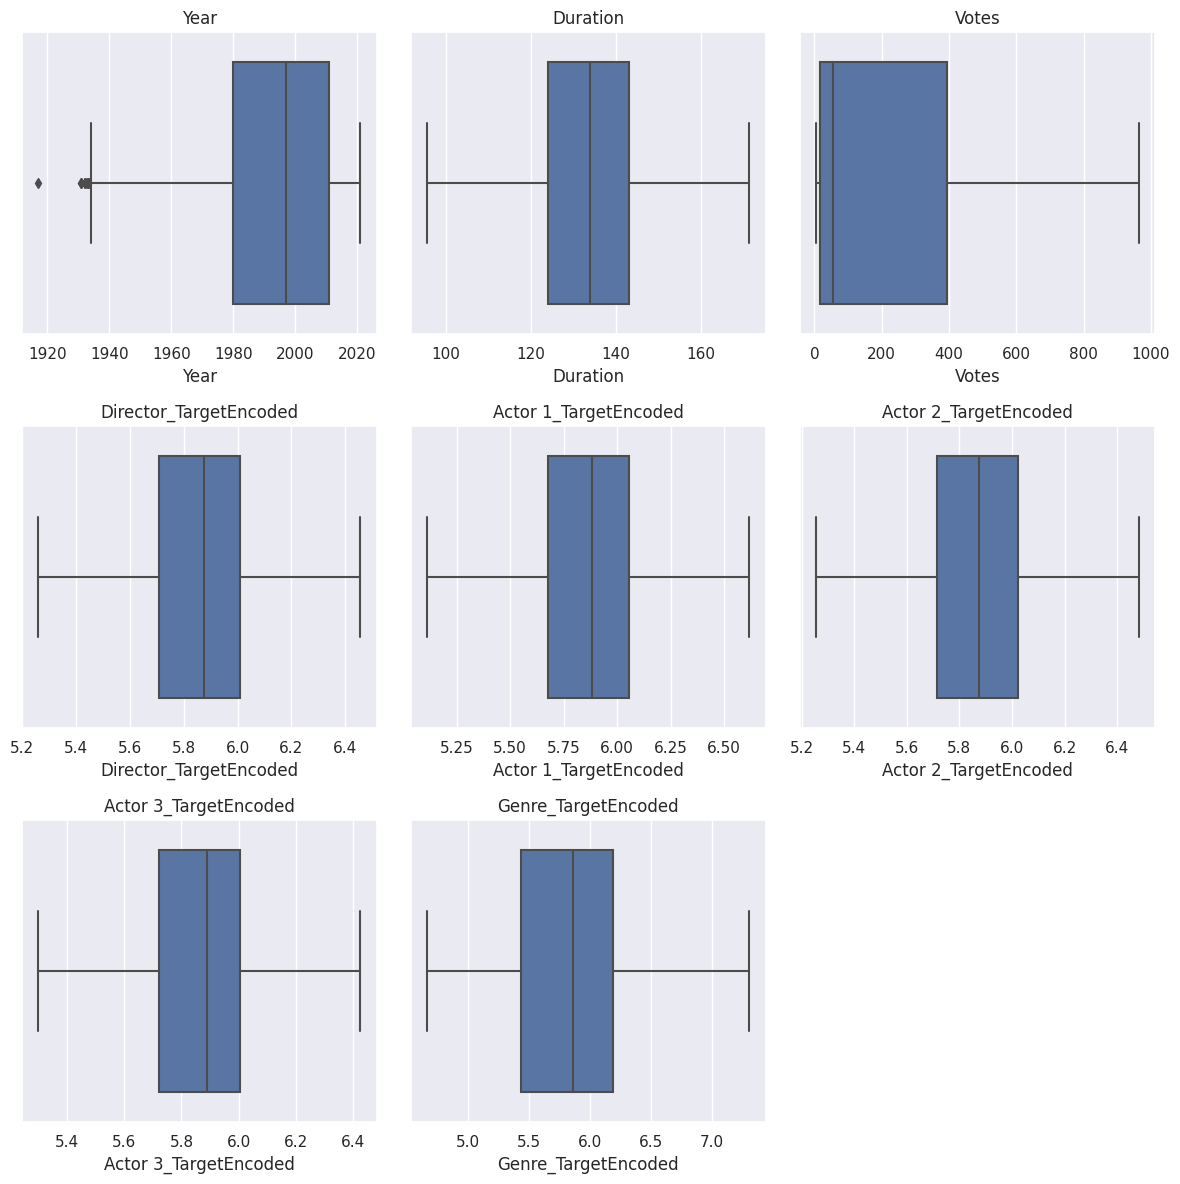

In [127]:
# Checking the visuals to see if the outliers are fixed

plt.figure(figsize=(12, 12))

for col in olt_x_train.select_dtypes(include=['number']).columns:
    plt.subplot(3, 3, olt_x_train.columns.get_loc(col) + 1)  # Adjust the subplot layout as needed
    sns.boxplot(x=olt_x_train[col])
    plt.title(col)

plt.tight_layout()
plt.show()

In [128]:
# Using the same treatment on the validation dataset

for i in olt_x_val.columns:
    col_q1 = olt_x_val[i].quantile(0.25)
    col_q3 = olt_x_val[i].quantile(0.75)
    col_iqr = col_q3 - col_q1

    upper_limit = col_q3 + (1.5 * col_iqr)
    lower_limit = col_q1 - (1.5 * col_iqr)

    if i in out_list:
        olt_x_val[i] = np.where(olt_x_val[i] > upper_limit, upper_limit,
                                   np.where(olt_x_val[i] < lower_limit, lower_limit, olt_x_val[i]))

#### Building the models on outlier treated data

In [133]:
ssc = StandardScaler()

scld_raw_x_train = pd.DataFrame(ssc.fit_transform(raw_x_train))
scld_raw_y_train = train_df['Rating']

scld_raw_x_val = pd.DataFrame(ssc.fit_transform(raw_x_val))
scld_raw_y_val = validation_df['Rating']

#### Using Standard Scaler of outlier treated data

In [138]:
ssc2 = StandardScaler()

scld_olt_x_train = pd.DataFrame(ssc2.fit_transform(olt_x_train))
scld_olt_y_train = train_df['Rating']

scld_olt_x_val = pd.DataFrame(ssc.fit_transform(olt_x_val))
scld_olt_y_val = validation_df['Rating']

In [139]:
# Building the models

# Linear Regression model
linear_model_olt_scld = LinearRegression()
linear_model_olt_scld.fit(scld_olt_x_train, scld_olt_y_train)
scld_olt_y_pred_train_lr = linear_model_olt_scld.predict(scld_olt_x_train)
scld_olt_y_pred_val_lr = linear_model_olt_scld.predict(scld_olt_x_val)

print("Accuracy Scores for Linear Regression model on scaled outlier treated data")
scld_olt_lr_mse = mean_squared_error(scld_olt_y_val, scld_olt_y_pred_val_lr)
scld_olt_train_lr_r2s = r2_score(scld_olt_y_train, scld_olt_y_pred_train_lr)
scld_olt_val_lr_r2s = r2_score(scld_olt_y_val, scld_olt_y_pred_val_lr)
print("Mean Squared Error :", scld_olt_lr_mse)
print("R-squared Score (Train) :", scld_olt_train_lr_r2s)
print("R-squared Score (Test) :", scld_olt_val_lr_r2s)
print("**************" * 7)

# Lasso Regression (L1 Regularization) going with alpha = 0.05, after checking various values
lasso_model_olt_scld = Lasso(alpha = 0.05)
lasso_model_olt_scld.fit(scld_olt_x_train, scld_olt_y_train)
scld_olt_y_pred_train_lar = lasso_model_olt_scld.predict(scld_olt_x_train)
scld_olt_y_pred_val_lar = lasso_model_olt_scld.predict(scld_olt_x_val)

print("Accuracy Scores for Lasso Regression (L1 Regularization) model on scaled outlier treated data")
scld_olt_lar_mse = mean_squared_error(scld_olt_y_val, scld_olt_y_pred_val_lar)
scld_olt_train_lar_r2s = r2_score(scld_olt_y_train, scld_olt_y_pred_train_lar)
scld_olt_val_lar_r2s = r2_score(scld_olt_y_val, scld_olt_y_pred_val_lar)
print("Mean Squared Error :", scld_olt_lar_mse)
print("R-squared Score (Train) :", scld_olt_train_lar_r2s)
print("R-squared Score (Test) :", scld_olt_val_lar_r2s)
print("**************" * 7)

# Ridge Regression (L2 Regularization) going with alpha = 0.05, after checking various values
ridge_model_olt_scld = Ridge(alpha = 0.05)
ridge_model_olt_scld.fit(scld_olt_x_train, scld_olt_y_train)
scld_olt_y_pred_train_ridge = ridge_model_olt_scld.predict(scld_olt_x_train)
scld_olt_y_pred_val_ridge = ridge_model_olt_scld.predict(scld_olt_x_val)

print("Accuracy Scores for Ridge Regression (L2 Regularization) model on scaled outlier treated data")
scld_olt_ridge_mse = mean_squared_error(scld_olt_y_val, scld_olt_y_pred_val_ridge)
scld_olt_train_ridge_r2s = r2_score(scld_olt_y_train, scld_olt_y_pred_train_ridge)
scld_olt_val_ridge_r2s = r2_score(scld_olt_y_val, scld_olt_y_pred_val_ridge)
print("Mean Squared Error :", scld_olt_ridge_mse)
print("R-squared Score (Train) :", scld_olt_train_ridge_r2s)
print("R-squared Score (Test) :", scld_olt_val_ridge_r2s)
print("**************" * 7)

# Elastic Net Regression (L1 and L2 Regularizations) going with alpha = 0.05, after checking various values
enet_model_olt_scld = ElasticNet(alpha = 0.05, random_state = 101)
enet_model_olt_scld.fit(scld_olt_x_train, scld_olt_y_train)
scld_olt_y_pred_train_enet = enet_model_olt_scld.predict(scld_olt_x_train)
scld_olt_y_pred_val_enet = enet_model_olt_scld.predict(scld_olt_x_val)

print("Accuracy Scores for Elastic Net Regression (L1 and L2 Regularizations) model on scaled outlier treated data")
scld_olt_enet_mse = mean_squared_error(scld_olt_y_val, scld_olt_y_pred_val_enet)
scld_olt_train_enet_r2s = r2_score(scld_olt_y_train, scld_olt_y_pred_train_enet)
scld_olt_val_enet_r2s = r2_score(scld_olt_y_val, scld_olt_y_pred_val_enet)
print("Mean Squared Error :", scld_olt_enet_mse)
print("R-squared Score (Train) :", scld_olt_train_enet_r2s)
print("R-squared Score (Test) :", scld_olt_val_enet_r2s)
print("**************" * 7)

# Decission Tree regression - Choosing max depth as 7 after trying different values
dtree_olt_scld = DecisionTreeRegressor(max_depth = 7)
dtree_olt_scld.fit(scld_olt_x_train, scld_olt_y_train)
scld_olt_y_pred_train_dtree = dtree_olt_scld.predict(scld_olt_x_train)
scld_olt_y_pred_val_dtree = dtree_olt_scld.predict(scld_olt_x_val)

print("Accuracy Scores for Decision Tree model on scaled outlier treated data")
scld_olt_dtree_mse = mean_squared_error(scld_olt_y_val, scld_olt_y_pred_val_dtree)
scld_olt_train_dtree_r2s = r2_score(scld_olt_y_train, scld_olt_y_pred_train_dtree)
scld_olt_val_dtree_r2s = r2_score(scld_olt_y_val, scld_olt_y_pred_val_dtree)
print("Mean Squared Error :", scld_olt_dtree_mse)
print("R-squared Score (Train) :", scld_olt_train_dtree_r2s)
print("R-squared Score (Test) :", scld_olt_val_dtree_r2s)
print("**************" * 7)

# Random Forest regression - Choosing max depth as 6 after trying different values
# Choosing the parameters after trying different values
rf_olt_scld = RandomForestRegressor(n_estimators = 100, random_state = 1, max_depth = 8)
rf_olt_scld.fit(scld_olt_x_train, scld_olt_y_train)
scld_olt_y_pred_train_rf = rf_olt_scld.predict(scld_olt_x_train)
scld_olt_y_pred_val_rf = rf_olt_scld.predict(scld_olt_x_val)

print("Accuracy Scores for Random Forest model on scaled outlier treated data")
scld_olt_rf_mse = mean_squared_error(scld_olt_y_val, scld_olt_y_pred_val_rf)
scld_olt_train_rf_r2s = r2_score(scld_olt_y_train, scld_olt_y_pred_train_rf)
scld_olt_val_rf_r2s = r2_score(scld_olt_y_val, scld_olt_y_pred_val_rf)
print("Mean Squared Error :", scld_olt_rf_mse)
print("R-squared Score (Train) :", scld_olt_train_rf_r2s)
print("R-squared Score (Test) :", scld_olt_val_rf_r2s)
print("**************" * 7)

# Gradient Boosting Regression model
gb_olt_scld = GradientBoostingRegressor(n_estimators = 100, max_depth = 5, random_state = 123)
gb_olt_scld.fit(scld_olt_x_train, scld_olt_y_train)
scld_olt_y_pred_train_gb = gb_olt_scld.predict(scld_olt_x_train)
scld_olt_y_pred_val_gb = gb_olt_scld.predict(scld_olt_x_val)

print("Accuracy Scores for Gradient Boost Regressor model on scaled outlier treated data")
scld_olt_gb_mse = mean_squared_error(scld_olt_y_val, scld_olt_y_pred_val_gb)
scld_olt_train_gb_r2s = r2_score(scld_olt_y_train, scld_olt_y_pred_train_gb)
scld_olt_val_gb_r2s = r2_score(scld_olt_y_val, scld_olt_y_pred_val_gb)
print("Mean Squared Error :", scld_olt_gb_mse)
print("R-squared Score (Train) :", scld_olt_train_gb_r2s)
print("R-squared Score (Test) :", scld_olt_val_gb_r2s)
print("**************" * 7)

# LGBoost Regression model - Max depth and Num_leaves = 3 after testing various values
lgb_olt_scld = lgb.LGBMRegressor(random_state = 11, max_depth = 3, num_leaves = 3, force_col_wise = True)
lgb_olt_scld.fit(scld_olt_x_train, scld_olt_y_train)
scld_olt_y_pred_train_lgb = lgb_olt_scld.predict(scld_olt_x_train)
scld_olt_y_pred_val_lgb = lgb_olt_scld.predict(scld_olt_x_val)

print("Accuracy Scores for LGBoost model on scaled outlier treated data")
scld_olt_lgb_mse = mean_squared_error(scld_olt_y_val, scld_olt_y_pred_val_lgb)
scld_olt_train_lgb_r2s = r2_score(scld_olt_y_train, scld_olt_y_pred_train_lgb)
scld_olt_val_lgb_r2s = r2_score(scld_olt_y_val, scld_olt_y_pred_val_lgb)
print("Mean Squared Error :", scld_olt_lgb_mse)
print("R-squared Score (Train) :", scld_olt_train_lgb_r2s)
print("R-squared Score (Test) :", scld_olt_val_lgb_r2s)
print("**************" * 7)

# XGBoost Regression model - Max depth = 2 after testing various values
xgb_olt_scld = xgb.XGBRegressor(random_state = 111, max_depth = 2)
xgb_olt_scld.fit(scld_olt_x_train, scld_olt_y_train)
scld_olt_y_pred_train_xgb = xgb_olt_scld.predict(scld_olt_x_train)
scld_olt_y_pred_val_xgb = xgb_olt_scld.predict(scld_olt_x_val)

print("Accuracy Scores for XGBoost model on outlier treated data")
scld_olt_xgb_mse = mean_squared_error(scld_olt_y_val, scld_olt_y_pred_val_xgb)
scld_olt_train_xgb_r2s = r2_score(scld_olt_y_train, scld_olt_y_pred_train_xgb)
scld_olt_val_xgb_r2s = r2_score(scld_olt_y_val, scld_olt_y_pred_val_xgb)
print("Mean Squared Error :", scld_olt_xgb_mse)
print("R-squared Score (Train) :", scld_olt_train_xgb_r2s)
print("R-squared Score (Test) :", scld_olt_val_xgb_r2s)
print("**************" * 7)

# Support Vector Regression model - Linear kernel
svr_linear_olt_scld = SVR(kernel = 'linear')
svr_linear_olt_scld.fit(scld_olt_x_train, scld_olt_y_train)
scld_olt_y_pred_train_svr_linear = svr_linear_olt_scld.predict(scld_olt_x_train)
scld_olt_y_pred_val_svr_linear = svr_linear_olt_scld.predict(scld_olt_x_val)

print("Accuracy Scores for Support Vector Model with linear kernel on scaled outlier treated data")
scld_olt_svr_linear_mse = mean_squared_error(scld_olt_y_val, scld_olt_y_pred_val_svr_linear)
scld_olt_train_svr_linear_r2s = r2_score(scld_olt_y_train, scld_olt_y_pred_train_svr_linear)
scld_olt_val_svr_linear_r2s = r2_score(scld_olt_y_val, scld_olt_y_pred_val_svr_linear)
print("Root Mean Squared Error :", scld_olt_svr_linear_mse)
print("R-squared Score (Train) :", scld_olt_train_svr_linear_r2s)
print("R-squared Score (Test) :", scld_olt_val_svr_linear_r2s)
print("**************" * 7)

# Support Vector Regression model - Polynomial kernel
svr_poly_olt_scld = SVR(kernel = 'poly')
svr_poly_olt_scld.fit(scld_olt_x_train, scld_olt_y_train)
scld_olt_y_pred_train_svr_poly = svr_poly_olt_scld.predict(scld_olt_x_train)
scld_olt_y_pred_val_svr_poly = svr_poly_olt_scld.predict(scld_olt_x_val)

print("Accuracy Scores for Support Vector Model with polynomial kernel on sclaed outlier treated data")
scld_olt_svr_poly_mse = mean_squared_error(scld_olt_y_val, scld_olt_y_pred_val_svr_poly)
scld_olt_train_svr_poly_r2s = r2_score(scld_olt_y_train, scld_olt_y_pred_train_svr_poly)
scld_olt_val_svr_poly_r2s = r2_score(scld_olt_y_val, scld_olt_y_pred_val_svr_poly)
print("Root Mean Squared Error :", scld_olt_svr_poly_mse)
print("R-squared Score (Train) :", scld_olt_train_svr_poly_r2s)
print("R-squared Score (Test) :", scld_olt_val_svr_poly_r2s)
print("**************" * 7)

# Support Vector Regression model - Sigmoid kernel
svr_sigmoid_olt_scld = SVR(kernel = 'sigmoid')
svr_sigmoid_olt_scld.fit(scld_olt_x_train, scld_olt_y_train)
scld_olt_y_pred_train_svr_sigmoid = svr_sigmoid_olt_scld.predict(scld_olt_x_train)
scld_olt_y_pred_val_svr_sigmoid = svr_sigmoid_olt_scld.predict(scld_olt_x_val)

print("Accuracy Scores for Support Vector Model with sigmoid kernel on sclaed outlier treated data")
scld_olt_svr_sigmoid_mse = mean_squared_error(scld_olt_y_val, scld_olt_y_pred_val_svr_sigmoid)
scld_olt_train_svr_sigmoid_r2s = r2_score(scld_olt_y_train, scld_olt_y_pred_train_svr_sigmoid)
scld_olt_val_svr_sigmoid_r2s = r2_score(scld_olt_y_val, scld_olt_y_pred_val_svr_sigmoid)
print("Root Mean Squared Error :", scld_olt_svr_sigmoid_mse)
print("R-squared Score (Train) :", scld_olt_train_svr_sigmoid_r2s)
print("R-squared Score (Test) :", scld_olt_val_svr_sigmoid_r2s)
print("**************" * 7)

# Support Vector Regression model - RBF kernel
svr_rbf_olt_scld = SVR(kernel = 'rbf')
svr_rbf_olt_scld.fit(scld_olt_x_train, scld_olt_y_train)
scld_olt_y_pred_train_svr_rbf = svr_rbf_olt_scld.predict(scld_olt_x_train)
scld_olt_y_pred_val_svr_rbf = svr_rbf_olt_scld.predict(scld_olt_x_val)

print("Accuracy Scores for Support Vector Model with rbf kernel on sclaed data")
scld_olt_svr_rbf_mse = mean_squared_error(scld_olt_y_val, scld_olt_y_pred_val_svr_rbf)
scld_olt_train_svr_rbf_r2s = r2_score(scld_olt_y_train, scld_olt_y_pred_train_svr_rbf)
scld_olt_val_svr_rbf_r2s = r2_score(scld_olt_y_val, scld_olt_y_pred_val_svr_rbf)
print("Root Mean Squared Error :", scld_olt_svr_rbf_mse)
print("R-squared Score (Train) :", scld_olt_train_svr_rbf_r2s)
print("R-squared Score (Test) :", scld_olt_val_svr_rbf_r2s)
print("**************" * 7)

Accuracy Scores for Linear Regression model on scaled outlier treated data
Mean Squared Error : 0.3757874344066941
R-squared Score (Train) : 0.6413849502755762
R-squared Score (Test) : 0.8005917954415644
**************************************************************************************************
Accuracy Scores for Lasso Regression (L1 Regularization) model on scaled outlier treated data
Mean Squared Error : 0.3823018787558264
R-squared Score (Train) : 0.6365751308699543
R-squared Score (Test) : 0.7971349644450536
**************************************************************************************************
Accuracy Scores for Ridge Regression (L2 Regularization) model on scaled outlier treated data
Mean Squared Error : 0.37578810294495235
R-squared Score (Train) : 0.641384950259984
R-squared Score (Test) : 0.800591440687782
**************************************************************************************************
Accuracy Scores for Elastic Net Regression (L1 and L2 

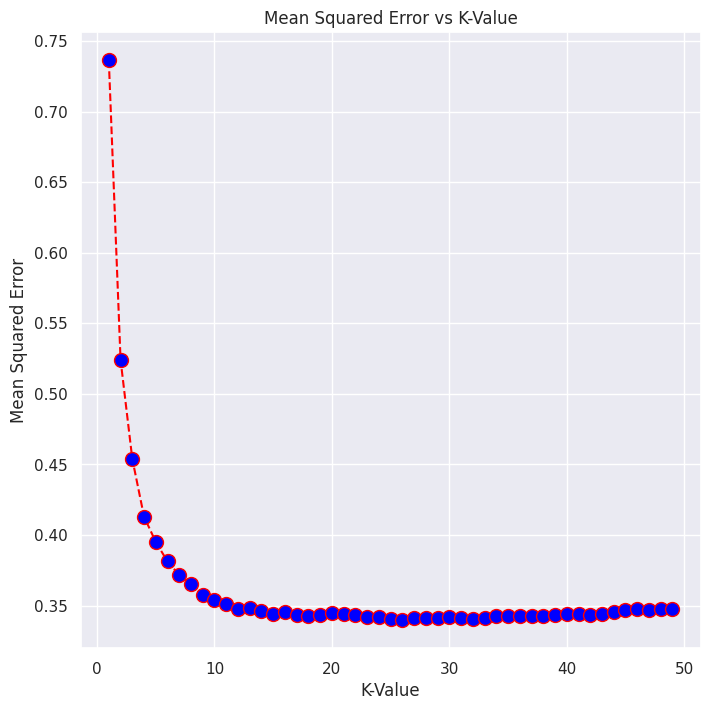

In [140]:
find_k(scld_olt_x_train, scld_olt_y_train, scld_olt_x_val, scld_olt_y_val)

In [141]:
# Building KNN regressor with k = 15
knn_olt_scld = KNeighborsRegressor(n_neighbors = 15)
knn_olt_scld.fit(scld_olt_x_train, scld_olt_y_train)
scld_olt_y_pred_train_knn = knn_olt_scld.predict(scld_olt_x_train)
scld_olt_y_pred_val_knn = knn_olt_scld.predict(scld_olt_x_val)

print("Accuracy Scores for KNN Regressor model on scaled raw data")
scld_olt_knn_mse = mean_squared_error(scld_olt_y_val, scld_olt_y_pred_val_knn)
scld_olt_train_knn_r2s = r2_score(scld_olt_y_train, scld_olt_y_pred_train_knn)
scld_olt_val_knn_r2s = r2_score(scld_olt_y_val, scld_olt_y_pred_val_knn)
print("Mean Squared Error :", scld_olt_knn_mse)
print("R-squared Score (Train) :", scld_olt_train_knn_r2s)
print("R-squared Score (Test) :", scld_olt_val_knn_r2s)
print("**************" * 7)

Accuracy Scores for KNN Regressor model on scaled raw data
Mean Squared Error : 0.34421236812570144
R-squared Score (Train) : 0.7681719712835728
R-squared Score (Test) : 0.8173468188921149
**************************************************************************************************


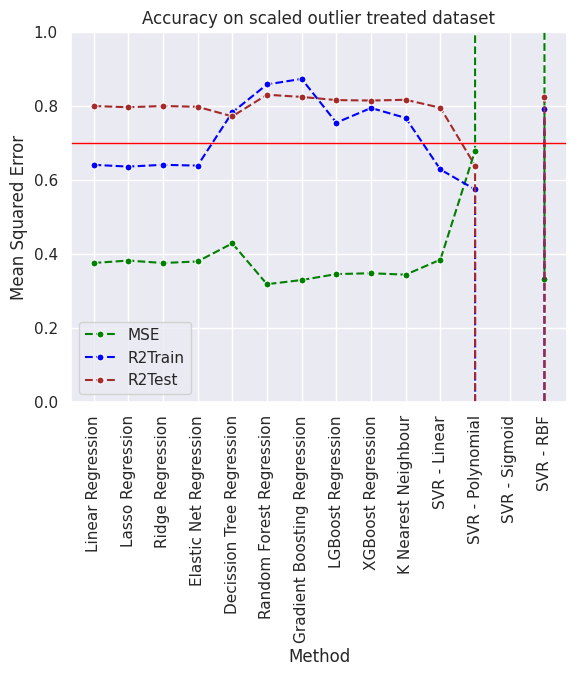

In [142]:
# Checking the accuracy of models on scled outlier treated data

scld_olt_mse_list = [scld_olt_lr_mse, scld_olt_lar_mse, scld_olt_ridge_mse, scld_olt_enet_mse, scld_olt_dtree_mse,
                     scld_olt_rf_mse, scld_olt_gb_mse, scld_olt_lgb_mse, scld_olt_xgb_mse, scld_olt_knn_mse,
                     scld_olt_svr_linear_mse, scld_olt_svr_poly_mse, scld_olt_svr_sigmoid_mse, scld_olt_svr_rbf_mse]

scld_olt_r2_train_list = [scld_olt_train_lr_r2s, scld_olt_train_lar_r2s, scld_olt_train_ridge_r2s, scld_olt_train_enet_r2s,
                          scld_olt_train_dtree_r2s, scld_olt_train_rf_r2s, scld_olt_train_gb_r2s, scld_olt_train_lgb_r2s,
                          scld_olt_train_xgb_r2s, scld_olt_train_knn_r2s, scld_olt_train_svr_linear_r2s,
                          scld_olt_train_svr_poly_r2s, scld_olt_train_svr_sigmoid_r2s, scld_olt_train_svr_rbf_r2s]

scld_olt_r2_test_list = [scld_olt_val_lr_r2s, scld_olt_val_lar_r2s, scld_olt_val_ridge_r2s, scld_olt_val_enet_r2s,
                         scld_olt_val_dtree_r2s, scld_olt_val_rf_r2s, scld_olt_val_gb_r2s, scld_olt_val_lgb_r2s,
                         scld_olt_val_xgb_r2s, scld_olt_val_knn_r2s, scld_olt_val_svr_linear_r2s, scld_olt_val_svr_poly_r2s,
                         scld_olt_val_svr_sigmoid_r2s, scld_olt_val_svr_rbf_r2s]

check_scores(scld_olt_mse_list, scld_olt_r2_train_list, scld_olt_r2_test_list, 'scaled outlier treated')

#### Cross validation of the top 3 models

In [143]:
# Cross validation on Random Forest with scaled raw data

train_rf_scld_raw = cross_val_score(rf_raw_scld, scld_raw_x_train, scld_raw_y_train, cv = 10, scoring = 'r2')
val_rf_scld_raw = cross_val_score(rf_raw_scld, scld_raw_x_val, scld_raw_y_val, cv = 10, scoring = 'r2')

print("Cross validation on Random Forest with scaled raw data")
print("Train Mean Accuracy", train_rf_scld_raw.mean())
print("**************")
print("Train Max Accuracy", train_rf_scld_raw.max())
print("**************"*7)
print("Test Mean Accuracy", val_rf_scld_raw.mean())
print("**************")
print("Test Max Accuracy", val_rf_scld_raw.max())
print("**************"*7)

elapsed_time_rf_scld_raw = timeit.timeit()
print(f"Elapsed Time: {elapsed_time_rf_scld_raw} seconds")

Cross validation on Random Forest with scaled raw data
Train Mean Accuracy 0.7634506953224289
**************
Train Max Accuracy 0.7806799950442782
**************************************************************************************************
Test Mean Accuracy 0.8458963800071568
**************
Test Max Accuracy 0.8653802713939653
**************************************************************************************************
Elapsed Time: 0.02444455199974982 seconds


In [144]:
# Cross validation on Random Forest with scaled outlier treated data

train_rf_scld_olt = cross_val_score(rf_olt_scld, scld_olt_x_train, scld_olt_y_train, cv = 10, scoring = 'r2')
val_rf_scld_olt = cross_val_score(rf_olt_scld, scld_olt_x_val, scld_olt_y_val, cv = 10, scoring = 'r2')

print("Cross validation on Random Forest with scaled outlier treated data")
print("Train Mean Accuracy", train_rf_scld_olt.mean())
print("**************")
print("Train Max Accuracy", train_rf_scld_olt.max())
print("**************"*7)
print("Test Mean Accuracy", val_rf_scld_olt.mean())
print("**************")
print("Test Max Accuracy", val_rf_scld_olt.max())
print("**************"*7)

elapsed_time_rf_scld_olt = timeit.timeit()
print(f"Elapsed Time: {elapsed_time_rf_scld_olt} seconds")

Cross validation on Random Forest with scaled outlier treated data
Train Mean Accuracy 0.7634506953224289
**************
Train Max Accuracy 0.7806799950442782
**************************************************************************************************
Test Mean Accuracy 0.8458963800071568
**************
Test Max Accuracy 0.8653802713939653
**************************************************************************************************
Elapsed Time: 0.020043616999828373 seconds


In [145]:
# Cross validation on Gradient Boosting with scaled outlier treated data

train_gb_scld_olt = cross_val_score(gb_olt_scld, scld_olt_x_train, scld_olt_y_train, cv = 10, scoring = 'r2')
val_gb_scld_olt = cross_val_score(gb_olt_scld, scld_olt_x_val, scld_olt_y_val, cv = 10, scoring = 'r2')

print("Cross validation on Gradient Boosting with scaled outlier treated data")
print("Train Mean Accuracy", train_gb_scld_olt.mean())
print("**************")
print("Train Max Accuracy", train_gb_scld_olt.max())
print("**************"*7)
print("Test Mean Accuracy", val_gb_scld_olt.mean())
print("**************")
print("Test Max Accuracy", val_gb_scld_olt.max())
print("**************"*7)

elapsed_time_gb_scld_olt = timeit.timeit()
print(f"Elapsed Time: {elapsed_time_gb_scld_olt} seconds")

Cross validation on Gradient Boosting with scaled outlier treated data
Train Mean Accuracy 0.7765689815027063
**************
Train Max Accuracy 0.7937240220397634
**************************************************************************************************
Test Mean Accuracy 0.8439225923397764
**************
Test Max Accuracy 0.8634957235132703
**************************************************************************************************
Elapsed Time: 0.02105119999987437 seconds


#### Saving the model for deployment and genearting the output file

In [146]:
# Saving model for deployment

final_model = rf_raw_scld
filename = 'Movie_Rating_Prediction.sav'
pickle.dump(final_model, open(filename, 'wb'))

In [147]:
#rest_df, test_df = [x for y, x in movies_df.groupby(movies_df['Rating'].isna())]

In [148]:
# Building the output file

out_df = rest_df

In [149]:
# Filling missing values in the dataset

# Filling missing years with the mode

out_df['Year'] = out_df['Year'].str.extract('([0-9]+)').astype(int)
mode_year_final = out_df['Year'].mode()
out_df['Year'] = out_df['Year'].fillna(mode_year_final)

In [150]:
# Filling the missing values in duration cokumn with median

out_df['Duration'] = out_df['Duration'].str.extract('([0-9]+)').astype(float)
median_duration_final = out_df['Duration'].median()
out_df['Duration'] = out_df['Duration'].fillna(median_duration_final)

In [151]:
# Filling missing values in the genre column based on Mode Imputaion method

# Already defined functions
# def expand_genre(df):
#     genres_df = df['Genre'].str.split(', ', expand = True)
#     df = pd.concat([df, genres_df], axis = 1)
#     df.rename(columns = {0 : 'Genre_1', 1 : 'Genre_2', 2 : 'Genre_3'}, inplace = True)
#     df.drop('Genre', axis = 1, inplace = True)
#     return df
# def drop_genre(df):
#     df.drop(['Genre_2','Genre_3'], axis = 1, inplace = True)
#     df.rename(columns = {'Genre_1' : 'Genre'}, inplace = True)
#     return df

out_df = expand_genre(out_df)
out_df = drop_genre(out_df)

mode_per_year_final = out_df.groupby('Year')['Genre'].apply(lambda x: x.mode().iloc[0])    # Gives a df with node of each year
out_df['Genre'] = out_df.apply(lambda row: mode_per_year[row['Year']] if pd.isnull(row['Genre']) else row['Genre'], axis=1)

In [152]:
# Filling the missing values in the names of Directors and actors as 'Not Available'

# Already defined functions
# def fill_names(df):
#     df['Director'] = df['Director'].fillna('Not Available')
#     df['Actor 1'] = df['Actor 1'].fillna('Not Available')
#     df['Actor 2'] = df['Actor 2'].fillna('Not Available')
#     df['Actor 3'] = df['Actor 3'].fillna('Not Available')
#     return df

rest_df = fill_names(rest_df)

In [153]:
# Droping the insignificant variables

out_df = out_df.drop(['Name'], axis = 1)

In [154]:
# Converting the Votes from object to int datatype

out_df['Votes'] = out_df['Votes'].str.extract('([0-9]+)').astype(int)

In [155]:
# Using Target encoding to encode the categorical variables
# As there are a diverese range of categorical variables

categorical_variables = out_df.select_dtypes(include = ['object']).columns.tolist()
encoder_final = ce.TargetEncoder(cols = categorical_variables)
encoded_df_final = encoder.fit_transform(out_df[categorical_variables], out_df['Rating'])
encoded_df_final.columns = [f"{col}_TargetEncoded" for col in categorical_variables]
out_df = pd.concat([out_df, encoded_df_final], axis = 1)

# Droping the categorical variables and keeping the encoded columns

out_df = out_df.drop(['Director', 'Actor 1', 'Actor 2', 'Actor 3', 'Genre'], axis = 1)

In [156]:
# Splitting dependent and independent variable

x_final = out_df.drop(['Rating'], axis = 1)
y_final = out_df['Rating']

In [157]:
# Scaling the training dataset using standard scaler

ssc_final = StandardScaler()
x_final = pd.DataFrame(ssc_final.fit_transform(x_final))

In [158]:
# Predicting the Rating using Random Forest model that was chosen as final model

y_pred = final_model.predict(x_final)

In [159]:
final_result = pd.DataFrame(y_pred)
final_result = final_result.rename(columns = {0 : "Predicted_Rating"})
final_result

,Predicted_Rating
0,6.861994
1,4.629847
2,5.494373
3,6.657862
4,5.703683
...,...
7914,5.848920
7915,6.030507
7916,4.944613
7917,4.918341


In [160]:
# Preparing the final data fram for output

final_result1 = pd.concat([(rest_df.drop(['Rating'], axis = 1)), rest_df['Rating'], pd.DataFrame(final_result)], axis = 1)
final_result1.head(5)

,Name,Year,Duration,Genre,Votes,Director,Actor 1,Actor 2,Actor 3,Rating,Predicted_Rating
1,#Gadhvi (He thought he was Gandhi),2019.0,109.0,Drama,8,Gaurav Bakshi,Rasika Dugal,Vivek Ghamande,Arvind Jangid,7.0,4.629847
3,#Yaaram,2019.0,110.0,"Comedy, Romance",35,Ovais Khan,Prateik,Ishita Raj,Siddhant Kapoor,4.4,6.657862
5,...Aur Pyaar Ho Gaya,1997.0,147.0,"Comedy, Drama, Musical",827,Rahul Rawail,Bobby Deol,Aishwarya Rai Bachchan,Shammi Kapoor,4.7,4.288688
6,...Yahaan,2005.0,142.0,"Drama, Romance, War","1,086",Shoojit Sircar,Jimmy Sheirgill,Minissha Lamba,Yashpal Sharma,7.4,5.267406
8,?: A Question Mark,2012.0,82.0,"Horror, Mystery, Thriller",326,Allyson Patel,Yash Dave,Muntazir Ahmad,Kiran Bhatia,5.6,5.687522


In [161]:
final_result1.to_csv("Indian_Movie_Rating_Prediction.csv")